# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

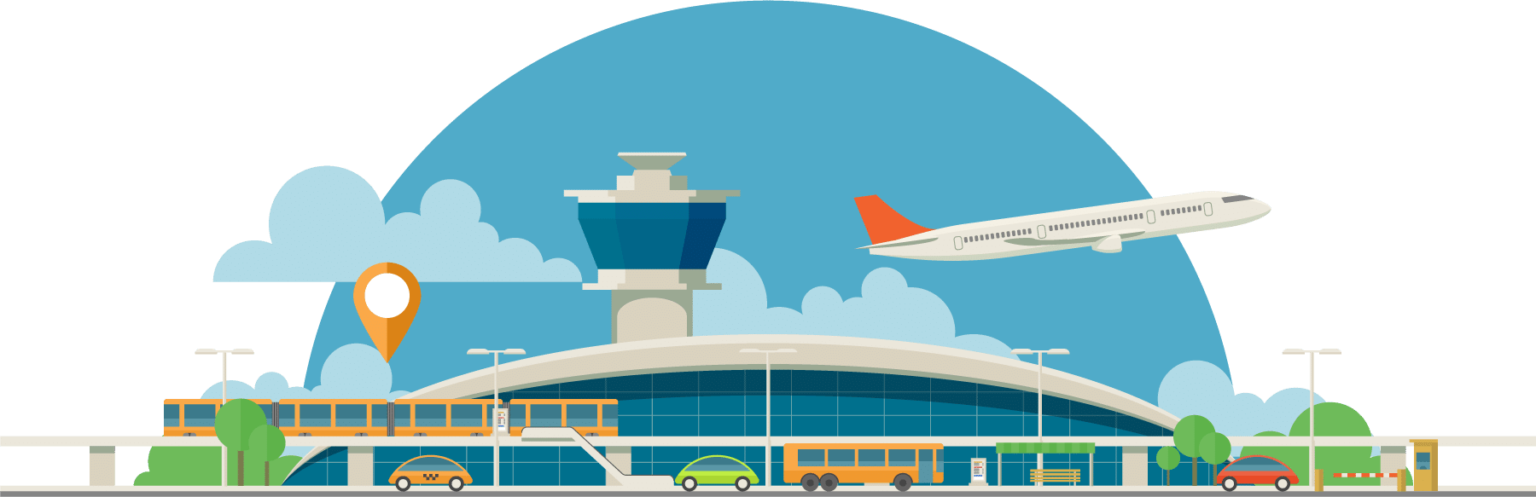

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [289]:
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.evaluate import bias_variance_decomp
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

np.random.seed(42)
"""Чтобы не мучить проверяющего лишней информацией в ноутбуке, 
отключим warning-и (в реальных проектах так делать не будем)"""
import warnings
warnings.filterwarnings("ignore")

# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
```

### Схема БД

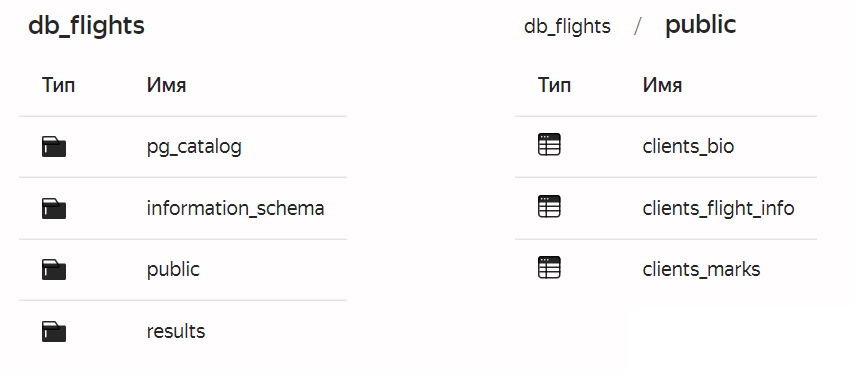

In [290]:
import psycopg2
import pandas as pd

with psycopg2.connect(
    dbname='db_flights', 
    user='mlhs_student', 
    password='mlhs_student', 
    host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net', 
    port='6432', 
    target_session_attrs='read-write',
    sslmode='verify-full',
) as conn:
    cur = conn.cursor()
    cur.execute('''
        select * from clients_flight_info
        join clients_marks using (id)
        join clients_bio using (id)
        ''')
    res = cur.fetchall()
    columns = [c.name for c in cur.description]
    df = pd.DataFrame(res, columns=columns)
    df.set_index('id', inplace=True)

In [291]:
assert df.shape == (129_549, 23)

In [292]:
df.head()

Customer Type   Type of Travel     class Flight Distance  \
id                                                                 
7      Loyal Customer  Business travel  Business          1963.0   
13  disloyal Customer  Business travel       Eco           453.0   
18     Loyal Customer  Personal Travel       Eco           821.0   
31  disloyal Customer  Business travel  Business           212.0   
39     Loyal Customer  Business travel  Business            67.0   

   Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
id                                                                             
7                         0.0                      0.0                   3.0   
13                       16.0                     30.0                   2.0   
18                        0.0                      0.0                   2.0   
31                        0.0                      0.0                   2.0   
39                        0.0                      0.0                   3.0   

   Departure/Arrival time convenient Ease of Online booking Gate location  \
id                                                                          
7                                3.0                    3.0           3.0   
13                               2.0                    2.0           4.0   
18                               5.0                    2.0           1.0   
31                               2.0                    2.0           1.0   
39                               3.0                    3.0           3.0   

    ... Inflight entertainment On-board service Leg room service  \
id  ...                                                            
7   ...                    5.0              5.0              5.0   
13  ...                    5.0              2.0              4.0   
18  ...                    5.0              5.0              2.0   
31  ...                    2.0              4.0              5.0   
39  ...                    4.0              4.0              4.0   

   Baggage handling Checkin service Inflight service cleanliness  \
id                                                                 
7               5.0             4.0              5.0         4.0   
13              4.0             2.0              4.0         5.0   
18              5.0             5.0              5.0         1.0   
31              5.0             5.0              4.0         2.0   
39              4.0             5.0              4.0         5.0   

               satisfaction  gender   age  
id                                         
7                 satisfied    Male  43.0  
13  neutral or dissatisfied    Male  24.0  
18  neutral or dissatisfied  Female  61.0  
31  neutral or dissatisfied    Male  35.0  
39                satisfied  Female  46.0  

[5 rows x 23 columns]

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [293]:
"""Преобразуем числовые столбцы к типу float"""
str_cols = [ 'Customer Type', 'Type of Travel', 'class', 'satisfaction', 'gender']
num_cols = df.columns.difference(str_cols)
df[num_cols] = df[num_cols].astype(float)

In [294]:
"""Посмотрим на общее количество пропусков во всех столбцах (по отдельным столбцам мы будем проводить анализ позднее)"""
print('Общее количество пропусков в наборе данных:', df.isna().sum().sum())

Общее количество пропусков в наборе данных: 1664


> _Видим, что пропуски в датасете есть_ 

Для ответа на вопрос о том, есть ли в датасете выбросы, построим простые визуализации признаков и сделаем соответствующие выводы. Более детальный анализ признаков будет проводиться далее.

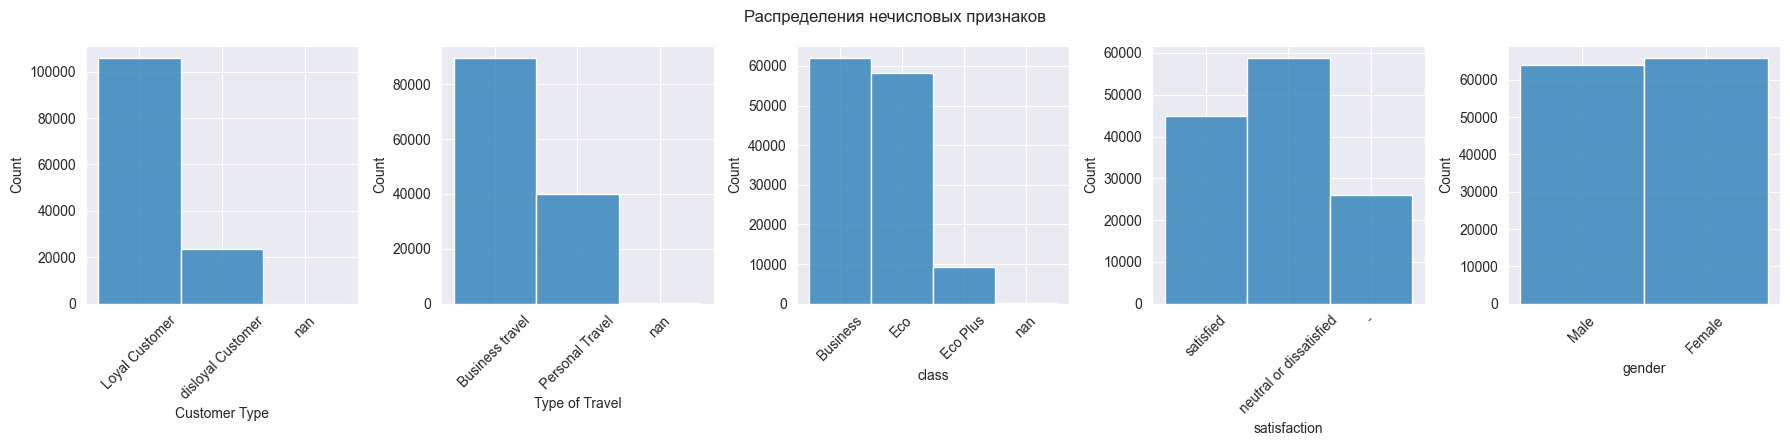

In [295]:
"""Также посмотрим на распределение нечисловых признаков"""
import seaborn as sns
import matplotlib.pyplot as plt
figure, ax = plt.subplots(1,5, figsize=(18,4.5))
plt.suptitle('Распределения нечисловых признаков')
for i, col in enumerate(str_cols): 
    sns.histplot(df[col], ax= ax[i])
    ax[i].tick_params(axis='x', labelrotation=45)
figure.tight_layout()

> _По гистограммам распределения видим, пропуски в нечисловых столбцах заданы как строка "nan", поэтому преобразуем их к np.nan_

In [296]:
df.replace('nan',np.nan,inplace=True)
print('Обновленной общее количество пропусков в наборе данных:', df.isna().sum().sum())

Обновленной общее количество пропусков в наборе данных: 1958


In [297]:
"""Также построим boxplot для числовых признаков, задав границы линий на 0.1 и 99.9 перцентилях"""
figure, ax = plt.subplots(3,6, figsize=(20,10))
plt.suptitle('Распределения числовых признаков')
for i, col in enumerate(num_cols): 
    sns.boxplot(df, x=col, ax= ax[i // 6, i % 6], whis=(0.1, 99.9))
figure.tight_layout()

> _По графикам видно, что даже за границами 0.1 и 99.9 перцентилей присутствуют значения, что позволяет предположить, что в выборке присутствуют выбросы. А наиболее ярким примером аномальных занчений является возраст в > 300 лет_

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

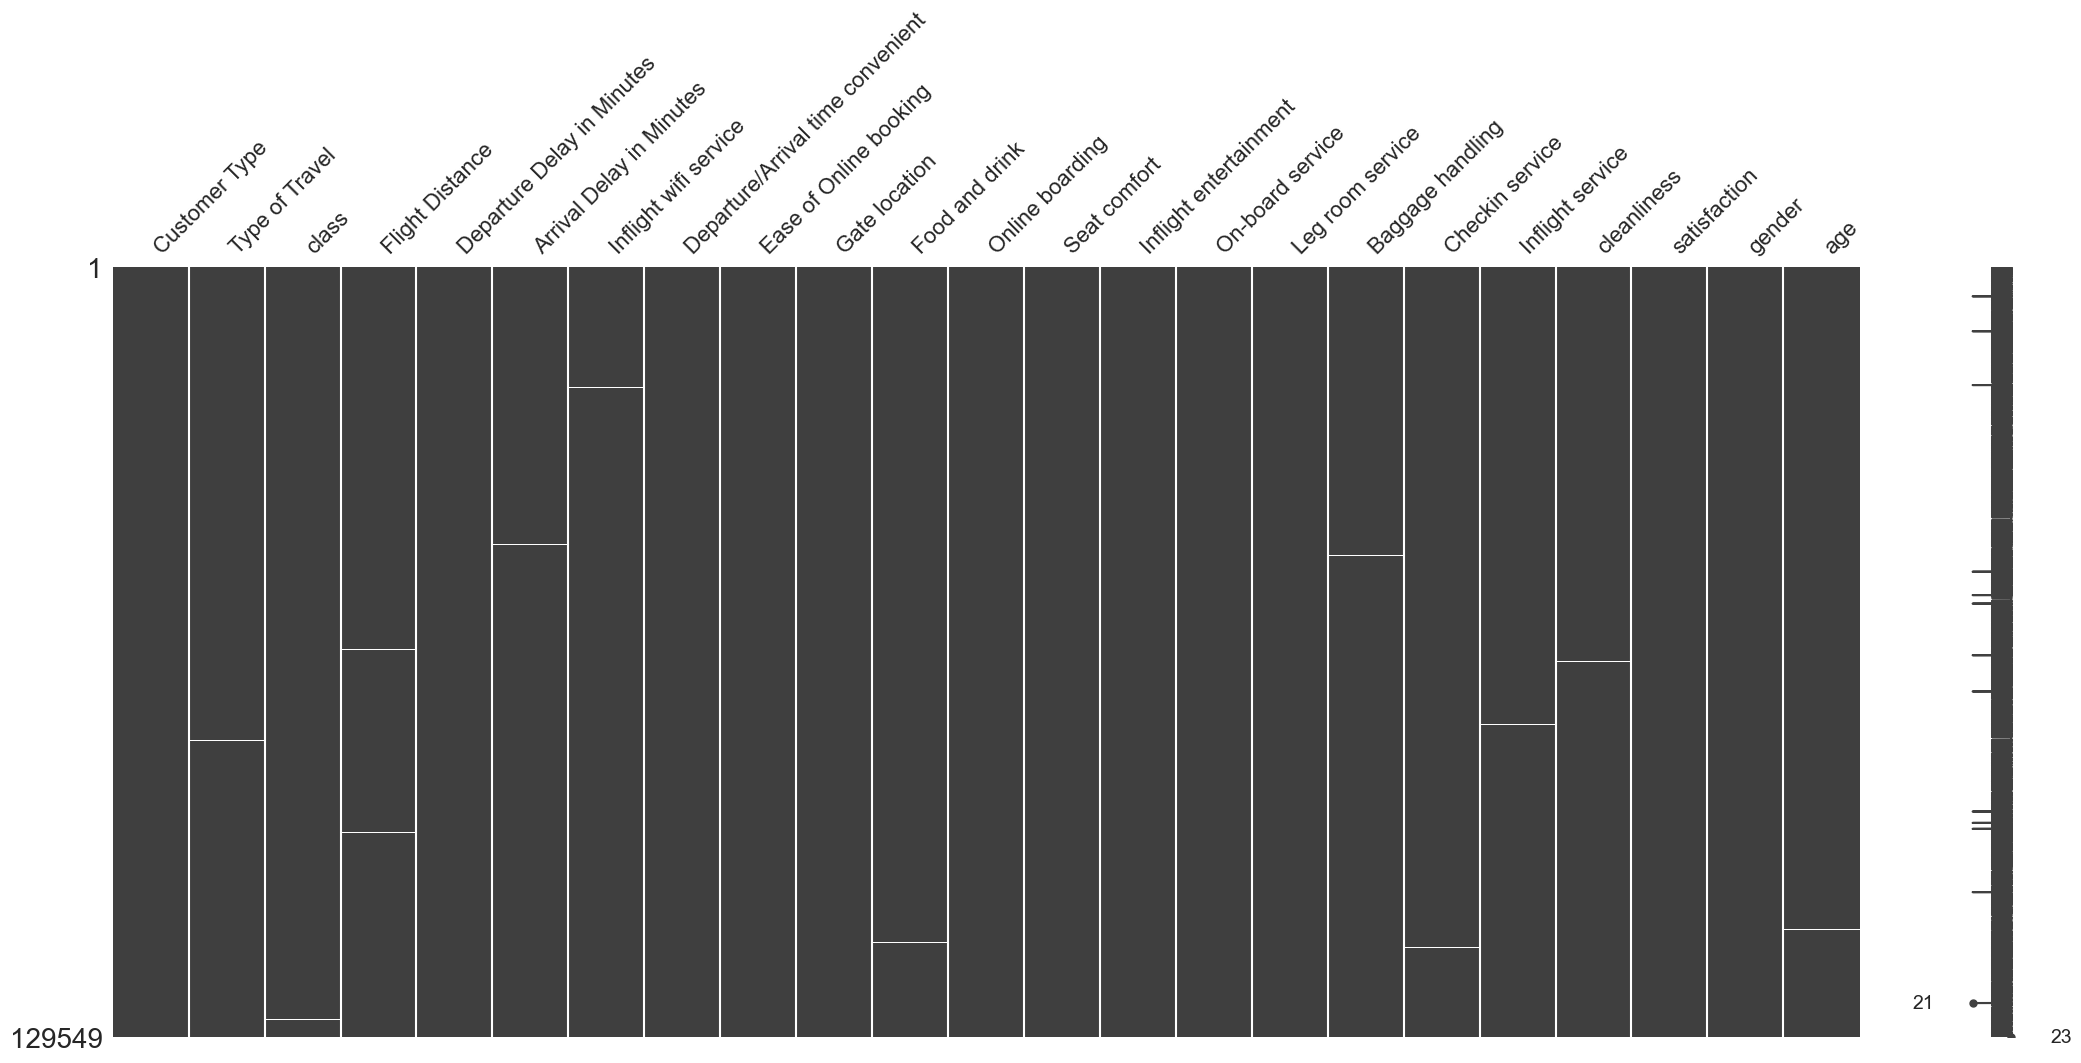

In [298]:
from missingno import missingno
missingno.matrix(df)

(129549, 23)


<Axes: >

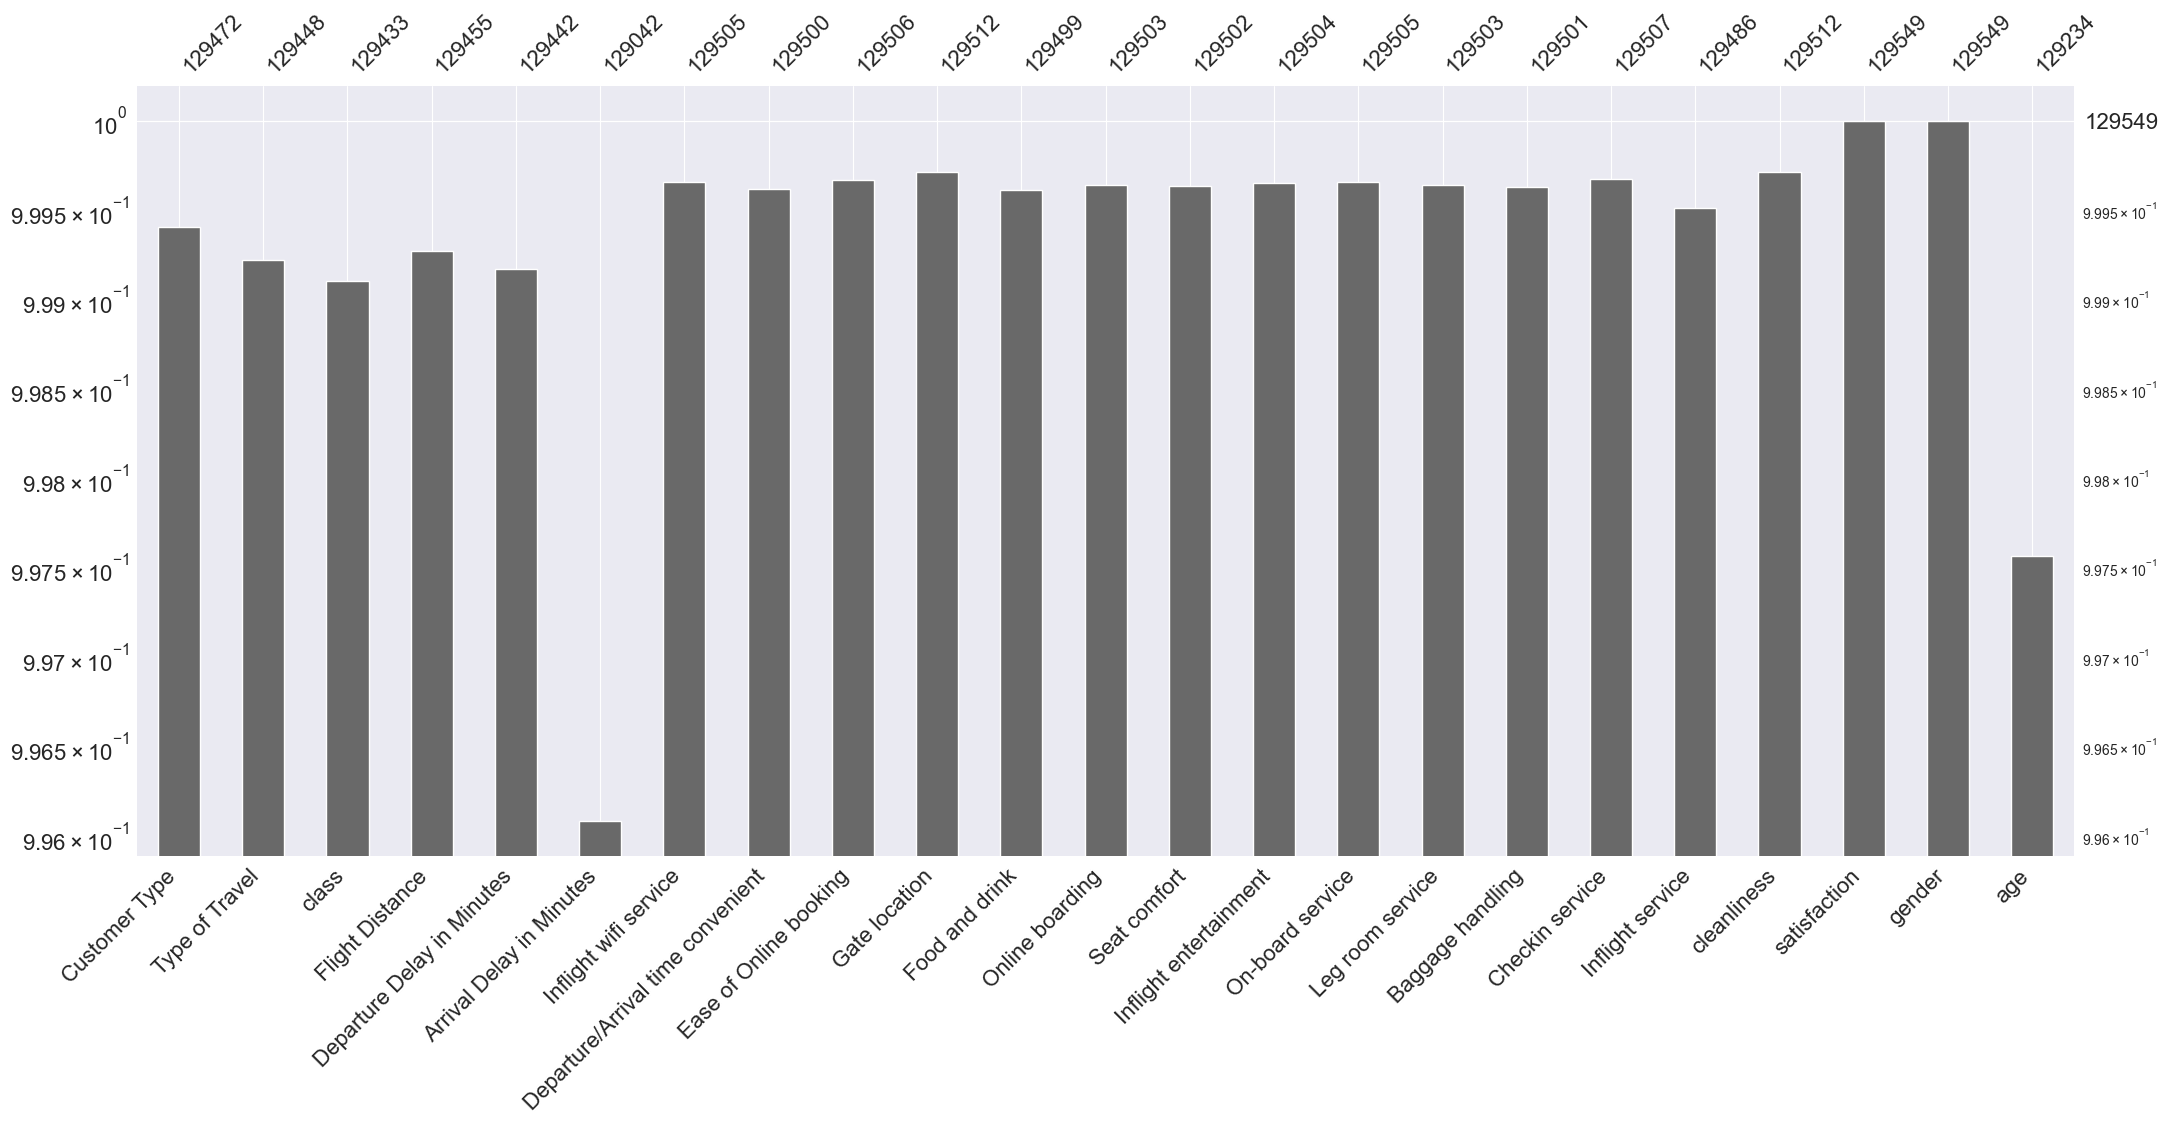

In [299]:
print(df.shape)
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [300]:
df_train = df[df.satisfaction != '-']
assert df_train.shape == (103_644, 23)
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [301]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)     

In [302]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [303]:
modes = X_train.mode().iloc[0] 

na_counts = [] 
for d in [df_test, X_train, X_val]: 
    d.fillna(modes, inplace=True)
    na_counts.append(d.isna().sum().sum())
    
print('Общее количество пропусков в наборе данных в df_test, X_train, X_val:', na_counts)

Общее количество пропусков в наборе данных в df_test, X_train, X_val: [0, 0, 0]


<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [304]:
X_train: pd.DataFrame = X_train
X_train.describe(include='all')

Customer Type   Type of Travel     class  Flight Distance  \
count            72550            72550     72550     72550.000000   
unique               2                2         3              NaN   
top     Loyal Customer  Business travel  Business              NaN   
freq             59406            50054     34793              NaN   
mean               NaN              NaN       NaN      1329.018332   
std                NaN              NaN       NaN      4764.369357   
min                NaN              NaN       NaN         0.000000   
25%                NaN              NaN       NaN       413.000000   
50%                NaN              NaN       NaN       844.000000   
75%                NaN              NaN       NaN      1744.000000   
max                NaN              NaN       NaN    379620.000000   

        Departure Delay in Minutes  Arrival Delay in Minutes  \
count                 72550.000000              72550.000000   
unique                         NaN                       NaN   
top                            NaN                       NaN   
freq                           NaN                       NaN   
mean                     15.859366                 16.645968   
std                      70.861937                 97.990293   
min                       0.000000                  0.000000   
25%                       0.000000                  0.000000   
50%                       0.000000                  0.000000   
75%                      12.000000                 13.000000   
max                    9282.000000              11760.000000   

        Inflight wifi service  Departure/Arrival time convenient  \
count            72550.000000                       72550.000000   
unique                    NaN                                NaN   
top                       NaN                                NaN   
freq                      NaN                                NaN   
mean                 2.733687                           3.065017   
std                  1.362172                           1.552254   
min                  0.000000                           0.000000   
25%                  2.000000                           2.000000   
50%                  3.000000                           3.000000   
75%                  4.000000                           4.000000   
max                 45.000000                          45.000000   

        Ease of Online booking  Gate location  ...  Seat comfort  \
count             72550.000000   72550.000000  ...  72550.000000   
unique                     NaN            NaN  ...           NaN   
top                        NaN            NaN  ...           NaN   
freq                       NaN            NaN  ...           NaN   
mean                  2.761006       2.982688  ...      3.445665   
std                   1.414843       1.316648  ...      1.346077   
min                   0.000000       0.000000  ...      0.000000   
25%                   2.000000       2.000000  ...      2.000000   
50%                   3.000000       3.000000  ...      4.000000   
75%                   4.000000       4.000000  ...      5.000000   
max                  28.000000      36.000000  ...     45.000000   

        Inflight entertainment  On-board service  Leg room service  \
count             72550.000000      72550.000000      72550.000000   
unique                     NaN               NaN               NaN   
top                        NaN               NaN               NaN   
freq                       NaN               NaN               NaN   
mean                  3.362150          3.383101          3.352364   
std                   1.360862          1.333758          1.360180   
min                   0.000000          0.000000          0.000000   
25%                   2.000000          2.000000          2.000000   
50%                   4.000000          4.000000          4.000000   
75%                   4.000000          4.000000          4.00000

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

По основным статистикам можно сделать следующие предположения относительно распределения признаков: 
- нечисловые признаки не содержат выбросов. Customer type, Type of Travel и gender бинарные и отношение числа объектов выборки с  наиболее часто встречающимся значением признака к общему числу объектов явно превышает 1%. Что касается признака class, то для него мы сделать такой вывод по основным статистикам не можем. Однако, ранее мы строили распределения этого признака и по гистограмме видели, что в выборке присутствует значительное количество объектов для каждого из значений;
- для некоторых числовых признаков максимальные значения существенно больше средних, медианы и даже 75 перцентиля, что может говорить о наличии выбросов. Например, для признака age, максимальное значение возраста в 544 очевидно является аномальным выбросом. Построенные выше boxplot-графики также показывали нам наличие выбросов; 
- для некоторых числовых признаков медиана существенно отличается от среднего значения, что позволяет предположить, что их распределение не является нормальным. В то же время, для признака age медиана очень близка среднему значений, что может говорить о нормальности распределения этого признака по объектам выборки.

Так как анализ распределения величин по основным статистикам является не очень показательным, построим диаграммы распределения таких признаков.     

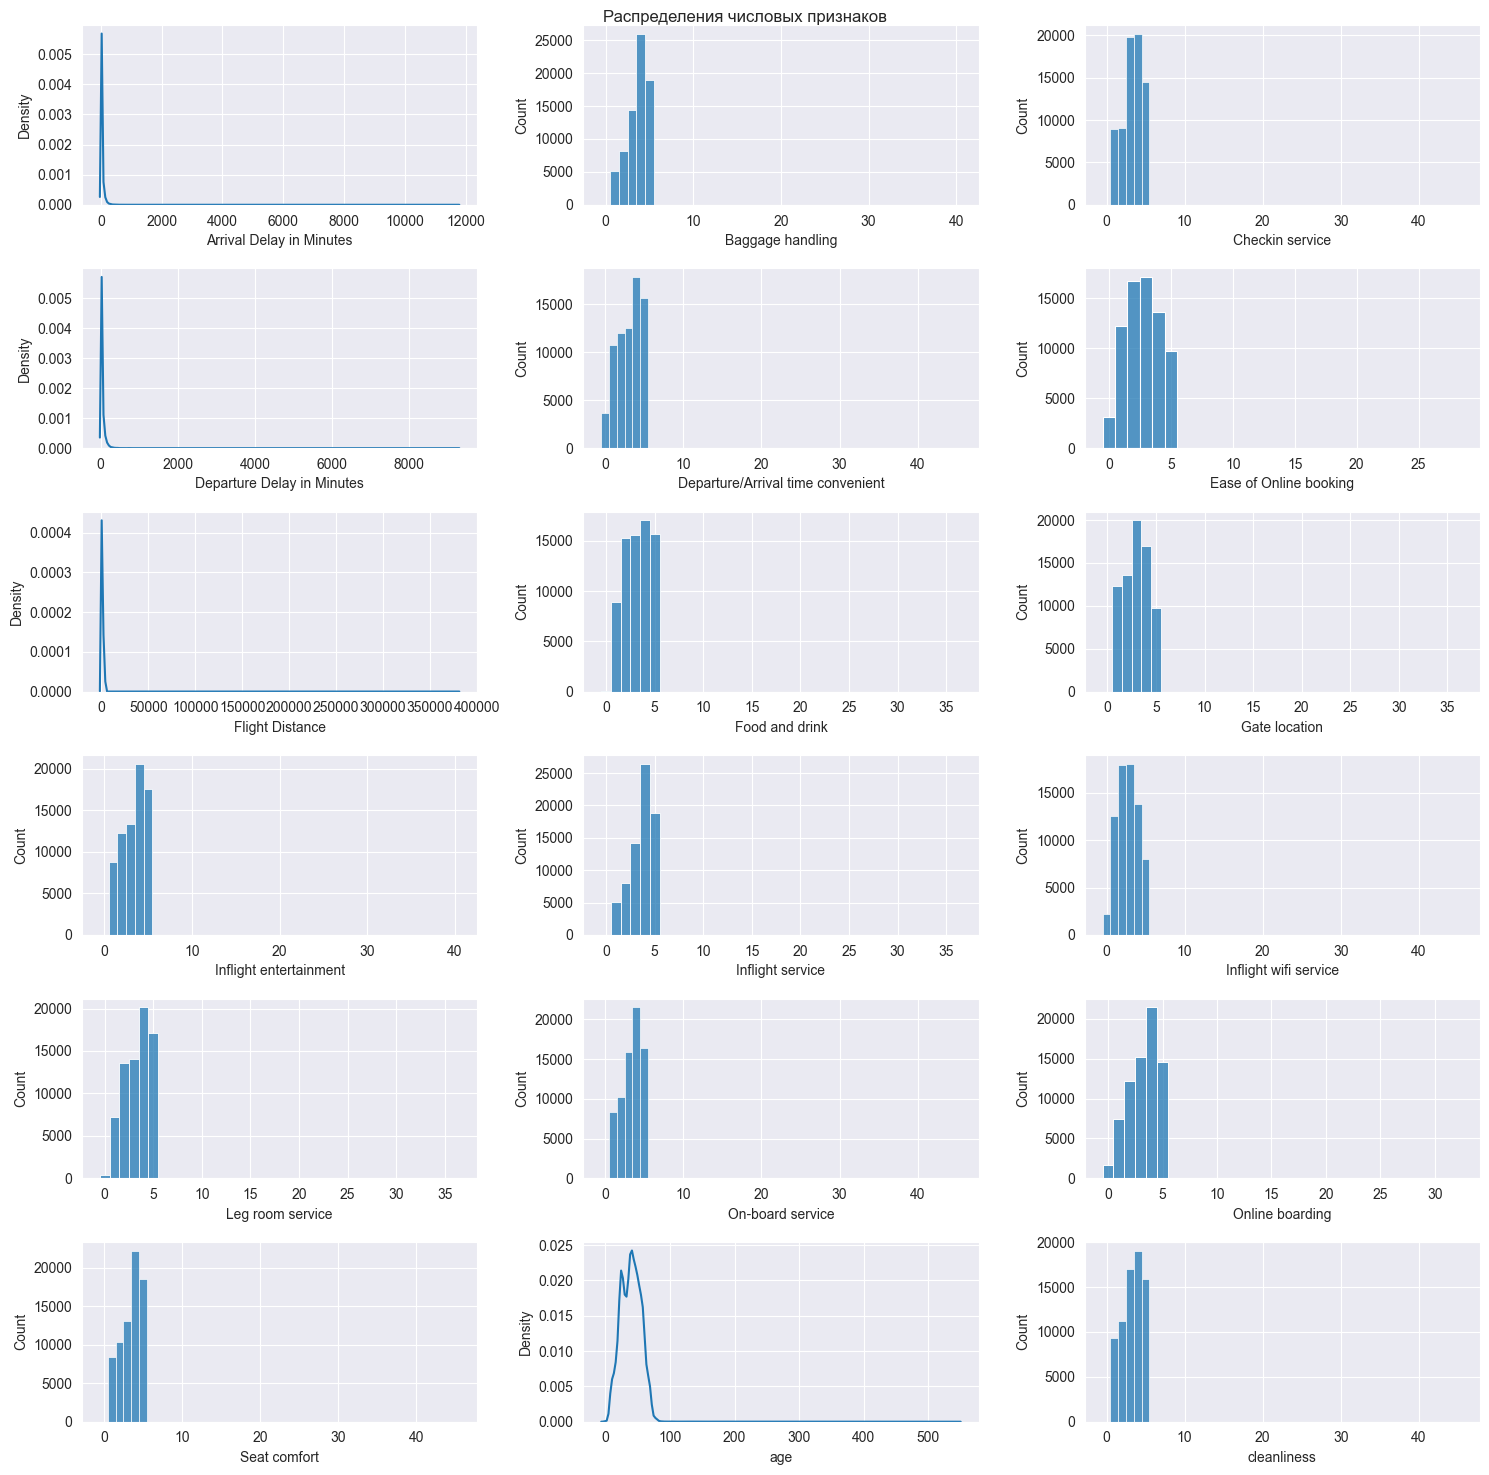

In [305]:
figure, ax = plt.subplots(6,3, figsize=(15,15))
plt.suptitle('Распределения числовых признаков')
for i, col in enumerate(num_cols):
    if X_train[col].nunique() > 50: 
        sns.kdeplot(X_train, x=col, ax= ax[i // 3, i % 3])
    else:
        sns.histplot(X_train, x=col, ax= ax[i // 3, i % 3], discrete=True)
figure.tight_layout()

Действительно, по графикам распределения видно, что у всех числовых признаков присутствуют "хвосты", а также, что распределения многих из них не похожи на нормальные. 

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [306]:
q = X_train[num_cols].quantile(0.996)
ind = X_train[(X_train[num_cols] <= q).all(axis=1)].index
X_train = X_train.loc[ind]
y_train = y_train.loc[ind]
X_train.shape, y_train.shape

((71395, 22), (71395,))

In [307]:
q = X_val[num_cols].quantile(0.996)
ind = X_val[(X_val[num_cols] <= q).all(axis=1)].index
X_val = X_val.loc[ind]
y_val = y_val[ind]
X_val.shape, y_val.shape

((30588, 22), (30588,))

In [308]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

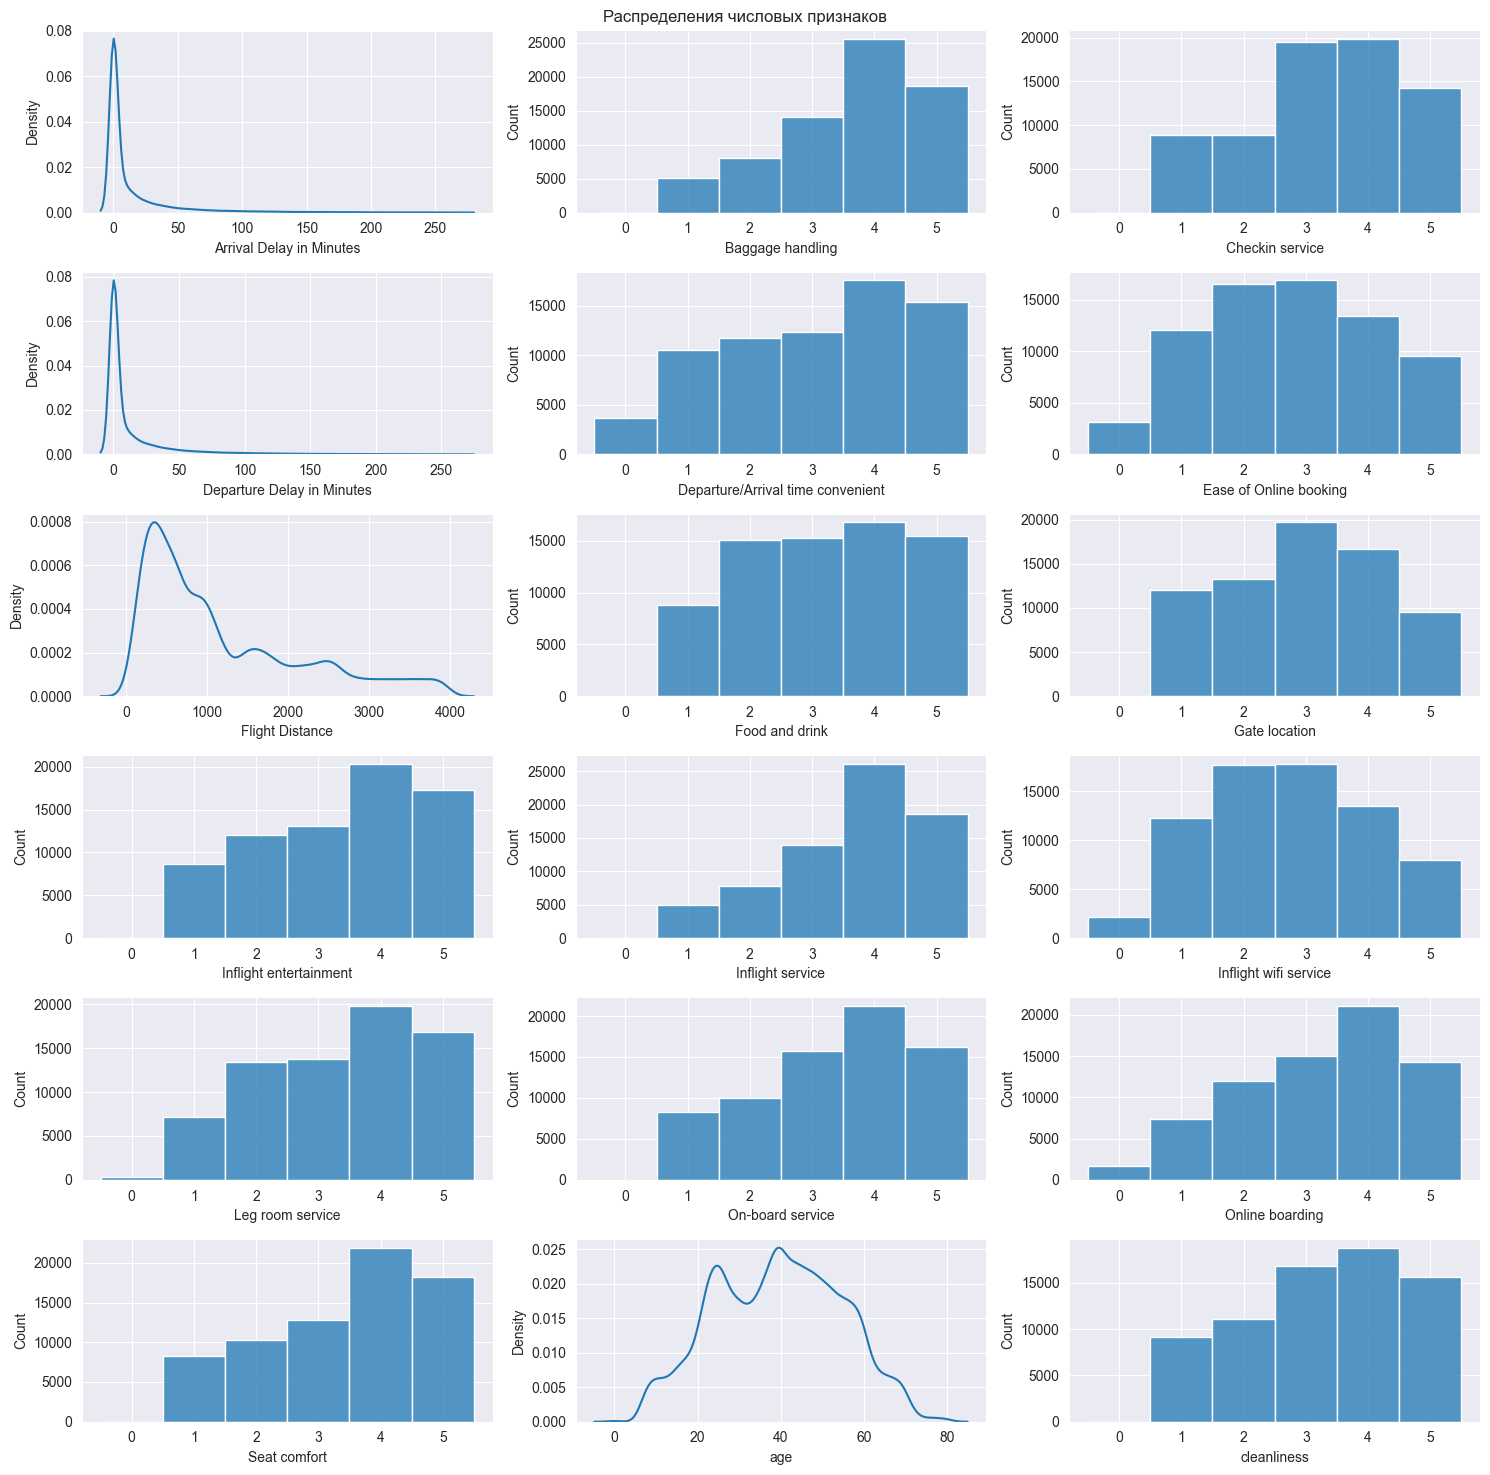

In [309]:
"""Посмотрим на распределение числовых признаков после удаления выбросов"""
figure, ax = plt.subplots(6,3, figsize=(15,15))
plt.suptitle('Распределения числовых признаков')
for i, col in enumerate(num_cols):
    if X_train[col].nunique() > 50: 
        sns.kdeplot(X_train, x=col, ax= ax[i // 3, i % 3])
    else:
        sns.histplot(X_train, x=col, ax= ax[i // 3, i % 3], discrete=True)
figure.tight_layout()

Видим, что графики существенно поменялись и теперь лучше отображают распределение признаков. В то же время, можно заметить, что у некоторых признаков для значений, равных 0, объектов сильно меньше, что тоже можно интерпретировать как выбросы. Но поскольку в задании не указано, что их нужно удалить, то мы их оставим  

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [310]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(set(df.select_dtypes(include='object').columns) - {'satisfaction'})

In [311]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [312]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, ax = plt.subplots(len(cols), 1, figsize=(8, 6 * len(cols)))
    for i, col in enumerate(cols):
        sns.countplot(df, x=col, hue=y, ax= ax[i]).set_title(f'{col} distribution')  
    figure.tight_layout()

In [313]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    fig, ax = plt.subplots(len(cols), 2, figsize=(14, 6 * len(cols)))
    for i, col in enumerate(cols):
        sns.kdeplot(df, x=col, hue=y, ax= ax[i,0]).set_title(f'{col} distribution')  
        sns.boxplot(df, x=col, hue=y, ax= ax[i,1]).set_title(f'{col} boxplot by target')  
    figure.tight_layout() 

In [314]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, ax = plt.subplots(len(cols), 1, figsize=(10, 6 * len(cols)))
    for i, col in enumerate(cols):
        sns.countplot(df, x=col, hue=y, width=0.6, ax= ax[i]).set_title(f'{col} distribution')  
    figure.tight_layout()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

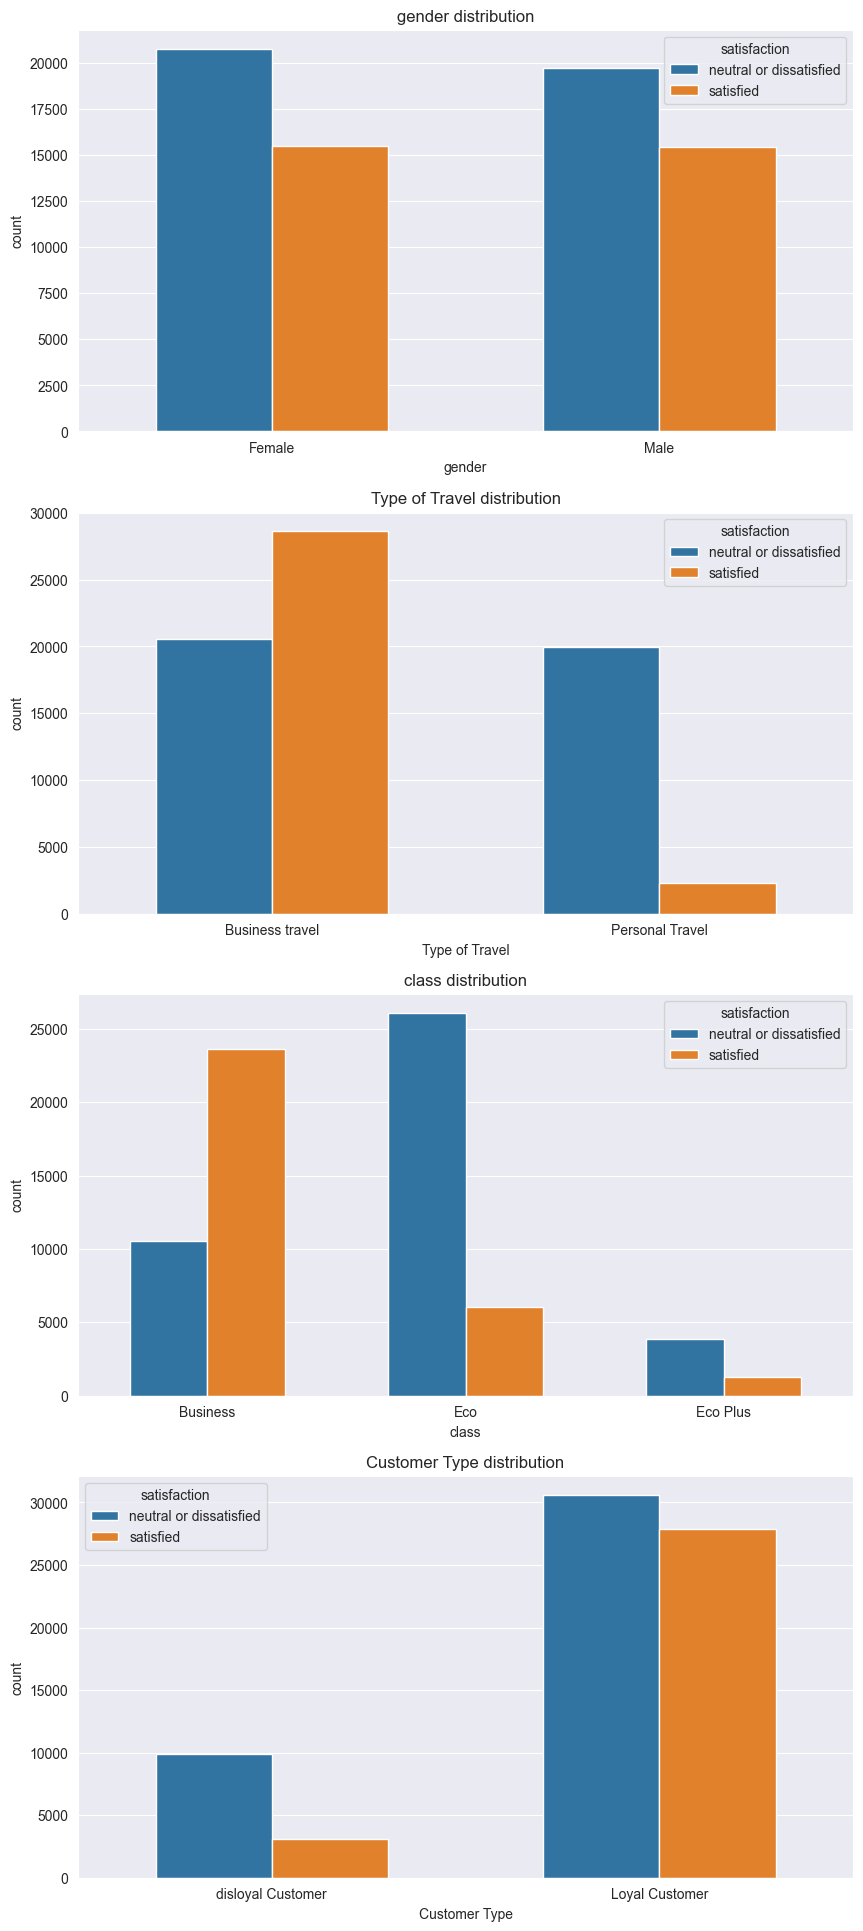

In [315]:
plot_categorical(categorical_cols, X_train, y_train)

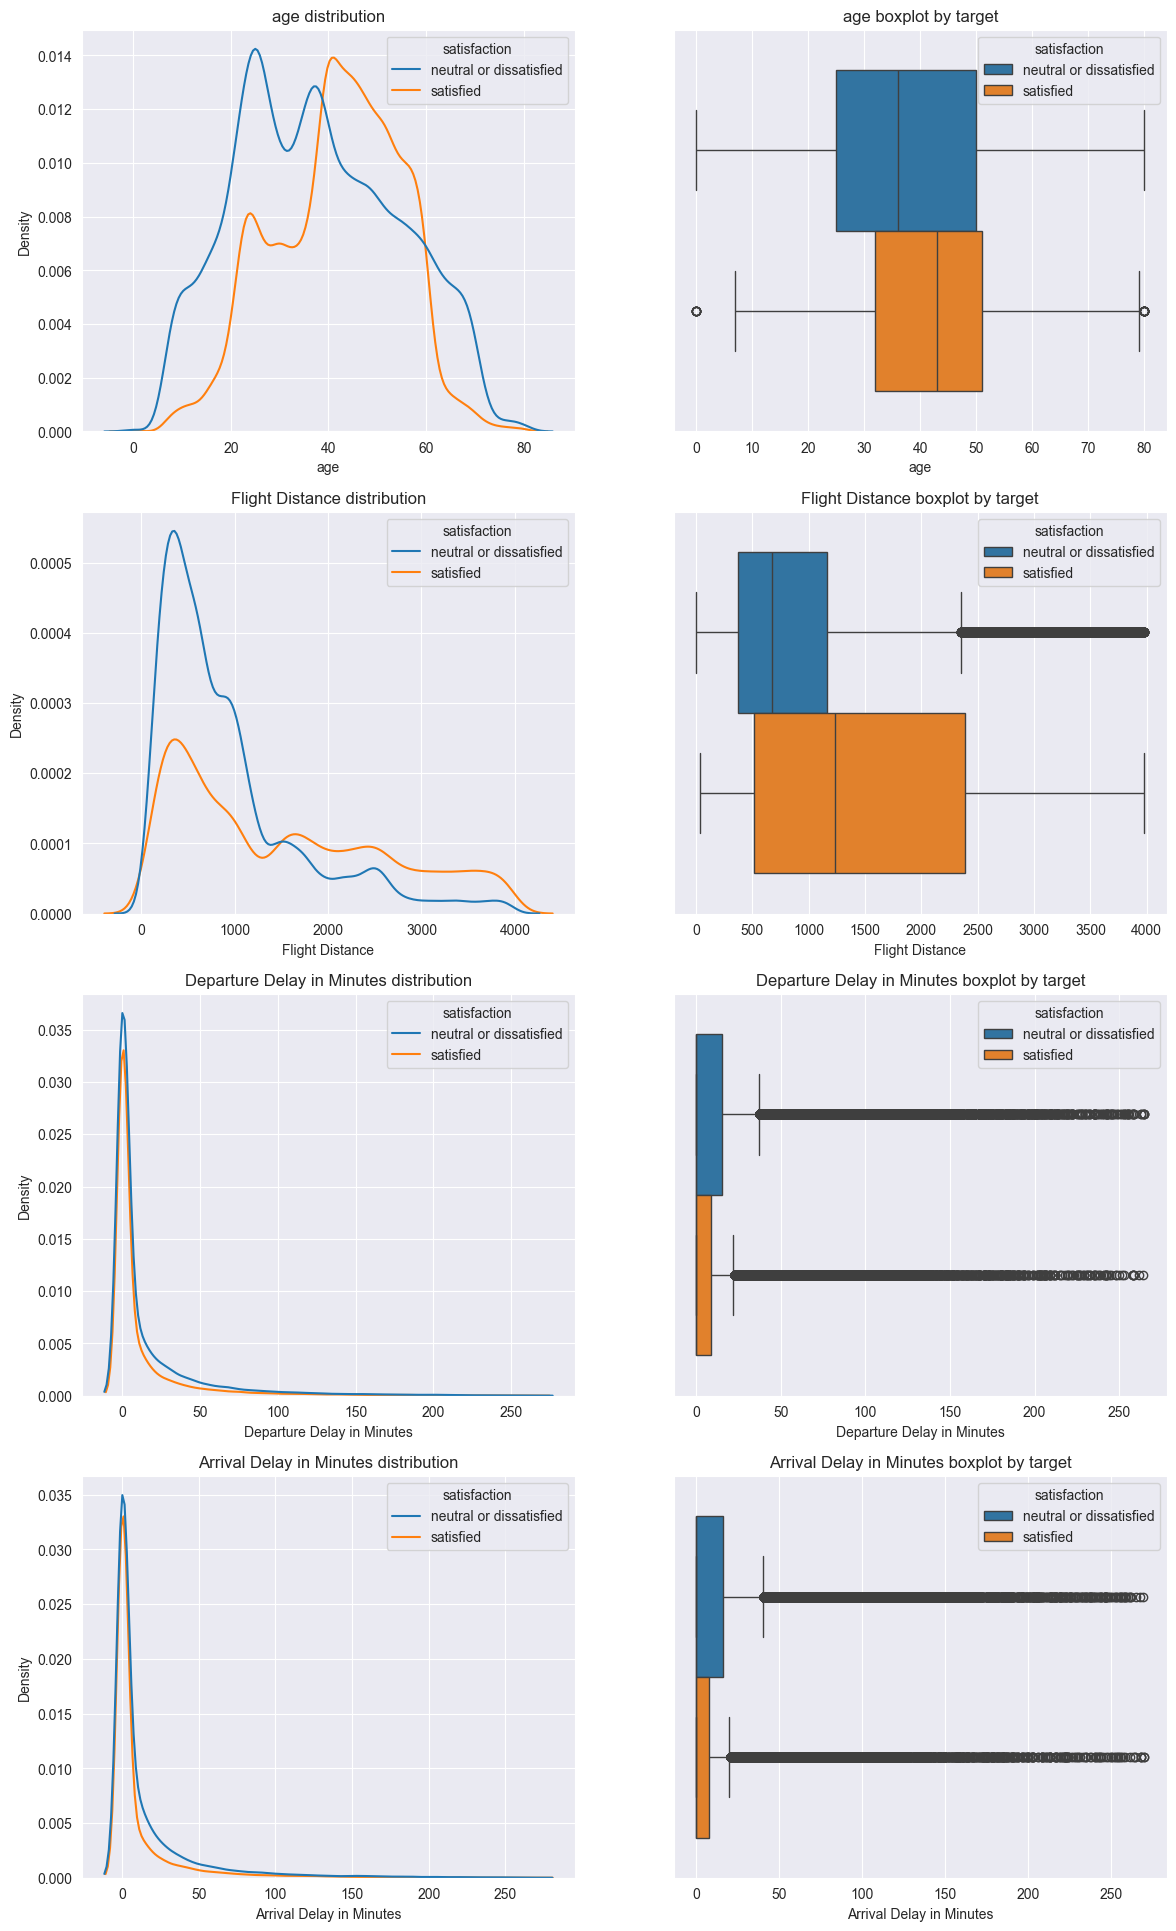

In [316]:
plot_continuous(continuous_cols, X_train, y_train)

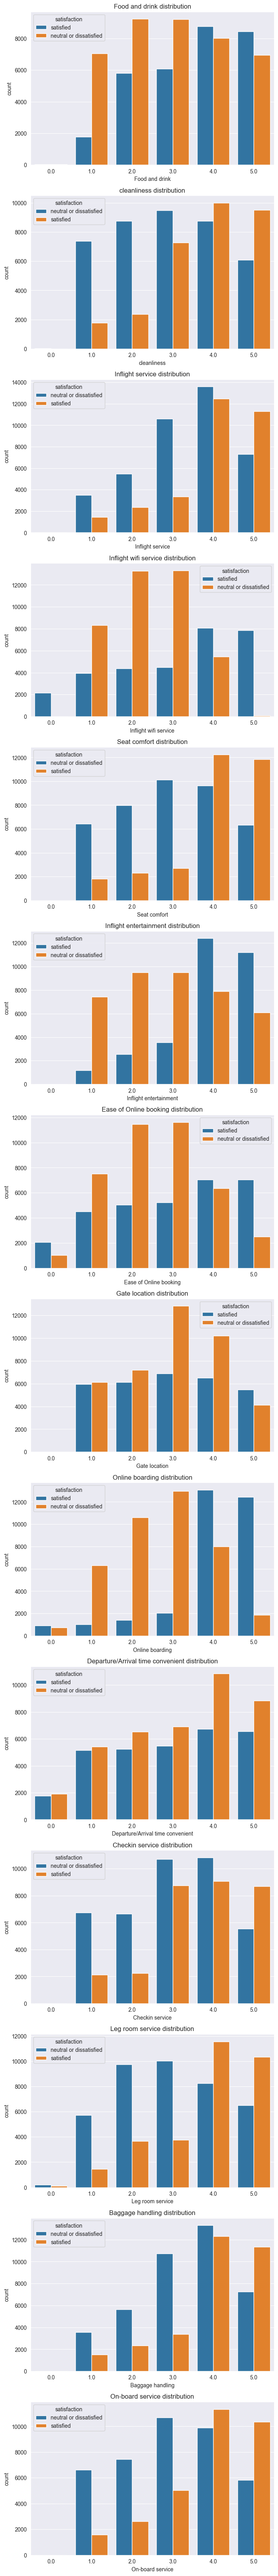

In [317]:
plot_ordinal(ordinal_cols, X_train, y_train)

Text(0.5, 1.0, 'Target (satisfaction) distribution')

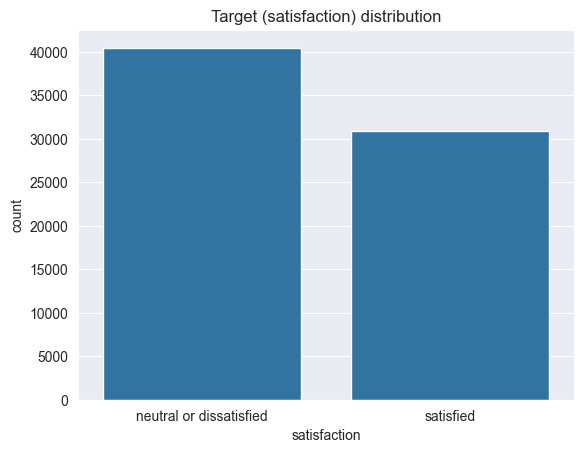

In [318]:
sns.countplot(x = y_train).set_title(f'Target (satisfaction) distribution')

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Выводы:
1. По распределению таргета в обучающей выборке видим, что количество объектов, относящихся к разным классам довольно близкое (не поровну, но в отношении примерно 3:4), т.е. можно сказать что классы сбалансированы. 
2. Среди континуальных признаков распределение Age по форме ближе к нормальному, а Depatrure и Arrival Delay, а также Flight Distance - ближе к лог-нормальному. 
3. Представляется, что равномерного распределения нет ни у одного признака (судя по графикам)   

Также можно отметить, что: 
- с ростом значения ординальным признаков растет число удовлетворенных полетом пассажиров (что логично т.к. значения этих признаков свидетельствует о более высоких оценках за полет). В то же время - с ростом оценки Inflight wifi service и Online boarding количество клиентов, удовлетвореных полетом, возрастает очень сильно по сравнению с количеством неудовлетворенных, что может говорить о том, что эти два признака будут иметь существенное влияние на прогнозные значения;    
- похожую картину можно заметить и для признака Type of travel, т.к. среди пассажиров, летящих с личными целями (а не деловыми) довольных на порядки меньше недовольных.


(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

Чтобы посмотреть, похожи ли распределения признаков в тренировочной, валидационной и тестовой выборке, соберем их вместе в один датафрей, но в отдельном столбце пропишем источник. А после этого построим распределение каждого признака с разбиением по источнику. Сравнив характер распределения признаков по каждому источнику, сможем ответить на поставленные вопрос 

In [319]:
X_train_copy = X_train.copy()
X_val_copy = X_val.copy()
df_test_copy = df_test.copy()

X_train_copy['dataset'] = "тренировочная"
X_val_copy['dataset'] = "валидационная"
df_test_copy['dataset'] = "тестовая"

agg_df = pd.concat((X_train_copy, X_val_copy, df_test_copy), axis=0)

In [320]:
figure, ax = plt.subplots(6,3, figsize=(15,15))
plt.suptitle('Распределения числовых признаков')
for i, col in enumerate(ordinal_cols + continuous_cols):
    if agg_df[col].nunique() > 50: 
        sns.kdeplot(agg_df, x=col, hue='dataset', ax= ax[i // 3, i % 3])
    else:
        sns.histplot(agg_df, x=col, hue='dataset', multiple='dodge', ax= ax[i // 3, i % 3], discrete=True)
figure.tight_layout()

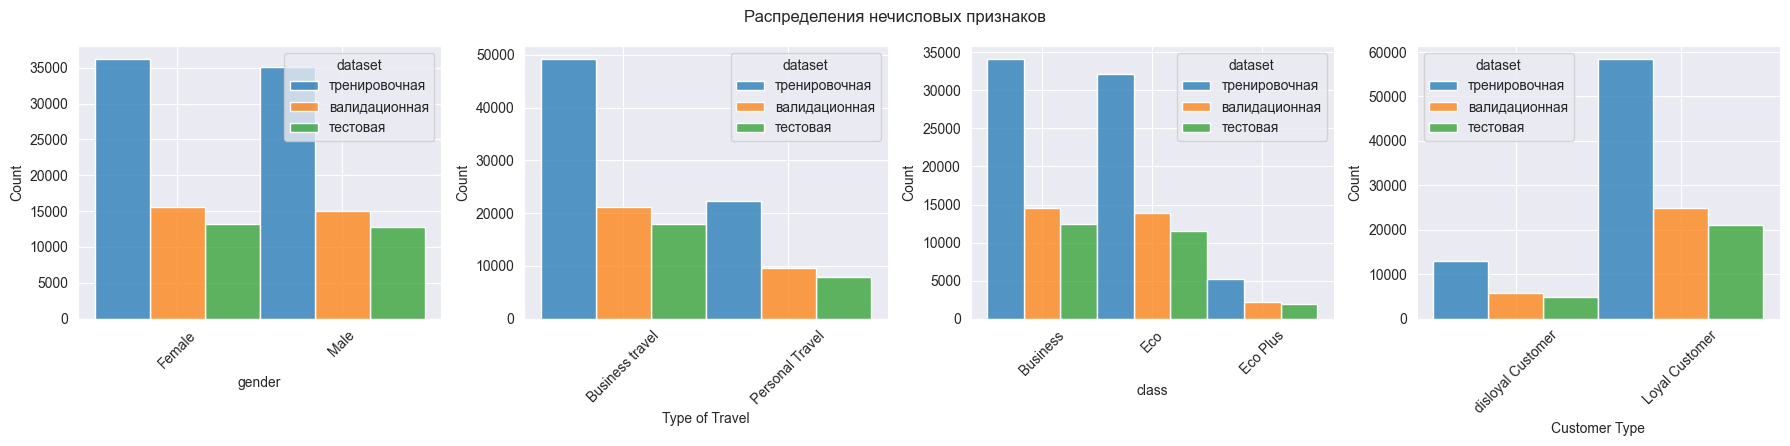

In [324]:
figure, ax = plt.subplots(1,4, figsize=(18,4.5))
plt.suptitle('Распределения нечисловых признаков')
for i, col in enumerate(categorical_cols): 
    sns.histplot(agg_df, x = col, hue='dataset', multiple='dodge', ax= ax[i])
    ax[i].tick_params(axis='x', labelrotation=45)
figure.tight_layout()

По графикам видим, что характер распределение признаков в трех выборках совпадает (к сожалению, в тестовой выборке выбросы мы не удаляли, поэтому на некоторых графиках kdeplot "хвосты" скрывают характер распределения; однако таких графиков всего три, в то время, как остальные показывают одинаковый характер распределения; считаю, что в данном случае можно их не учитывать и предположить, что после удаления выбросов в тесте, характер распределения этих трех признаков также будет одинаков для всех выборок) 

Теперь посмотрим на распределение таргета в тренировочной и валидационной части (в тесте у нас таргета не было исходно)

In [329]:
agg_y_1 = pd.DataFrame()
agg_y_1['satisfaction'] = y_train
agg_y_1['dataset'] = "тренировочная"

agg_y_2 = pd.DataFrame()
agg_y_2['satisfaction'] = y_val
agg_y_2['dataset'] = "валидационная"

agg_y = pd.concat((agg_y_1, agg_y_2), axis=0)
sns.countplot(agg_y, x = 'satisfaction', hue='dataset').set_title(f'Target (satisfaction) distribution')
plt.show()


Из графика видим, что и характер распределения целевой переменной в тренировочной и валидационной выборках также одинаков

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

Поскольку в указанных столбцах присутствуют 0, то их логарифмирование в чистом виде приведет к -inf, поэтому при логарифмировании добавим к значению небольшой EPSILON. Исходя из ответа на этот вопрос от преподавателя в чате группы [https://t.me/c/1935491788/2/1703](https://t.me/c/1935491788/2/1703), будем считать, что это подходящий вариант

In [185]:
EPSILON = 1e-6  

cols_to_change = ["Departure Delay in Minutes", "Arrival Delay in Minutes"]
ds_to_change = [X_train, X_val, df_test]
for ds in ds_to_change:
    for col in cols_to_change: 
        ds['Log of ' + col] =np.log(ds[col] + EPSILON)
        ds.drop(columns=[col], inplace=True)

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

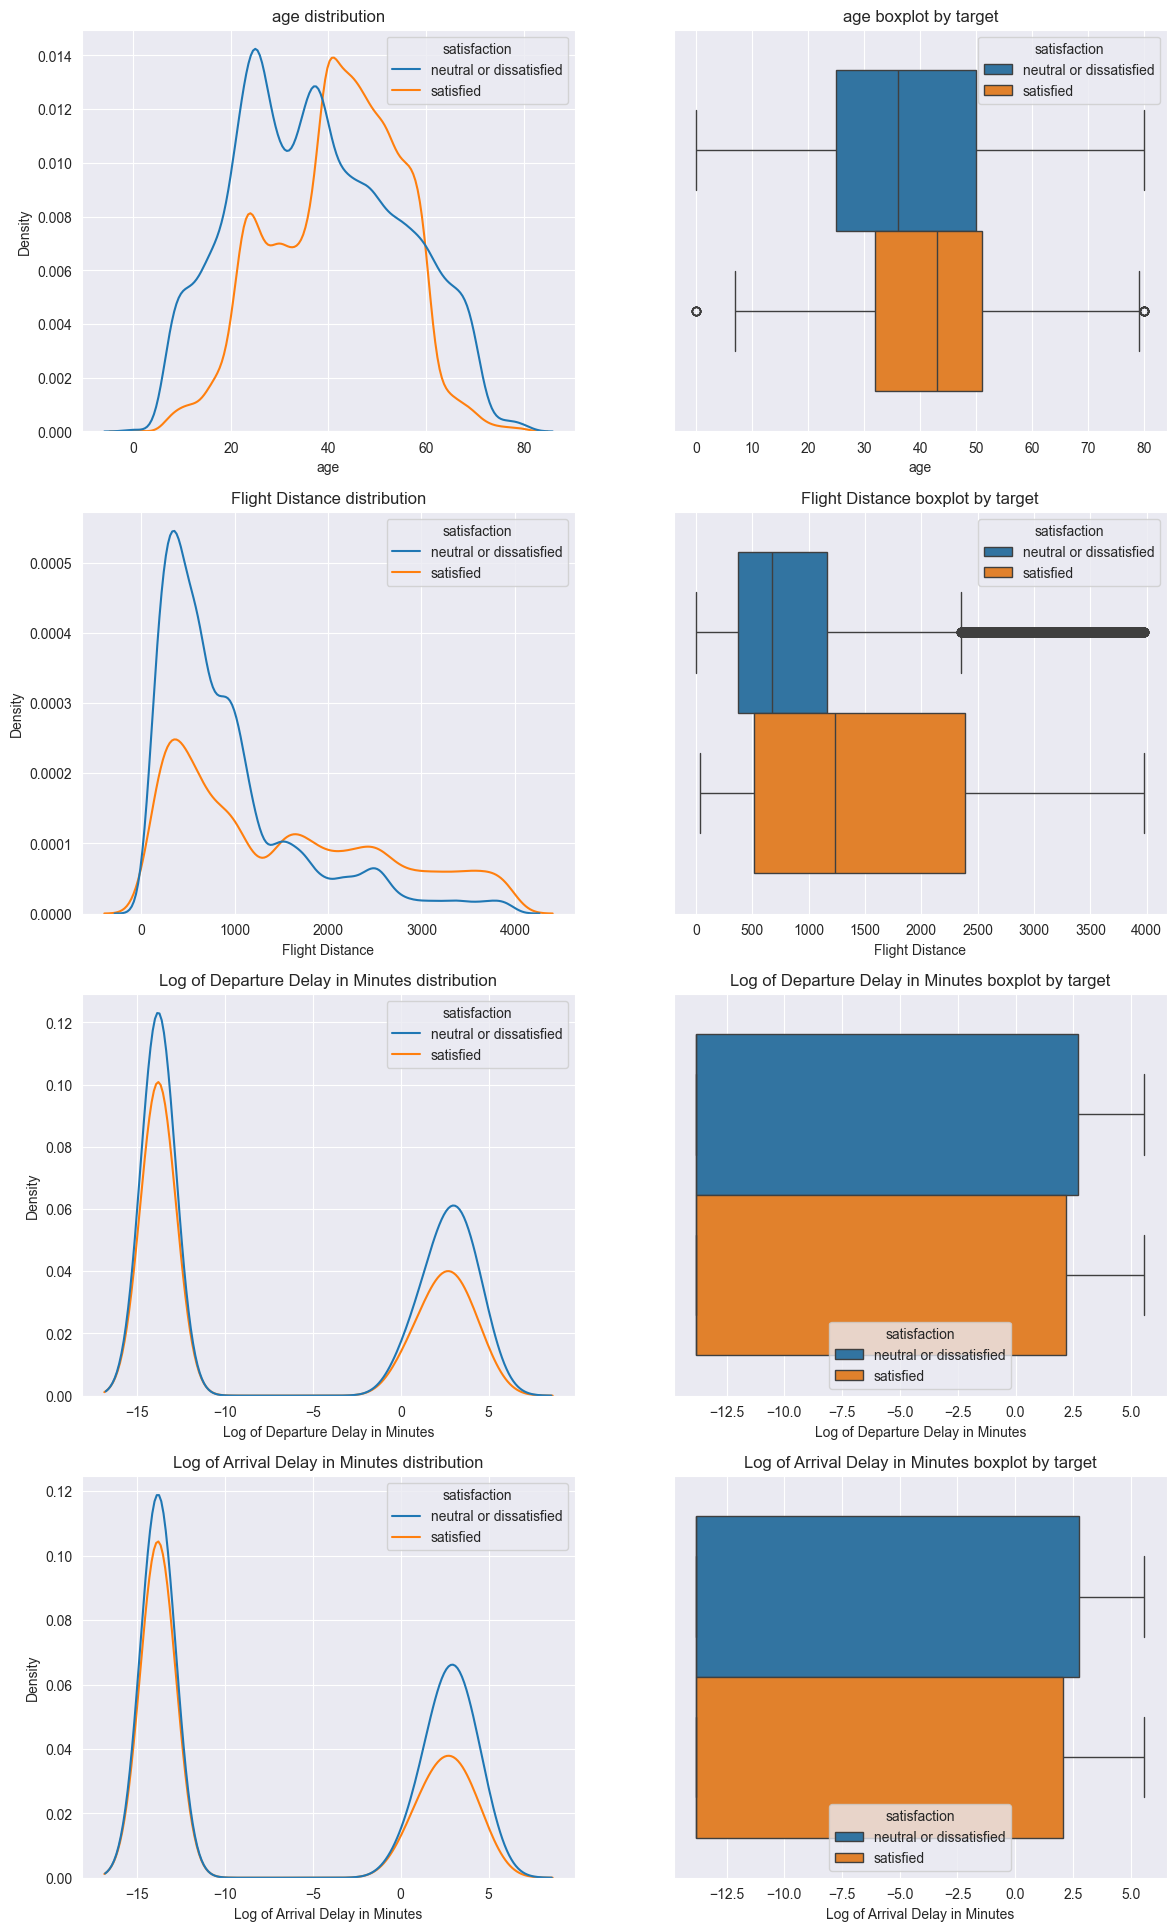

In [186]:
continuous_cols = [c for c in continuous_cols if c not in cols_to_change] + ['Log of ' + c for c in cols_to_change]
plot_continuous(continuous_cols,X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [187]:
y_train = y_train.apply(lambda x: 1 if x=='satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x=='satisfied' else 0)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

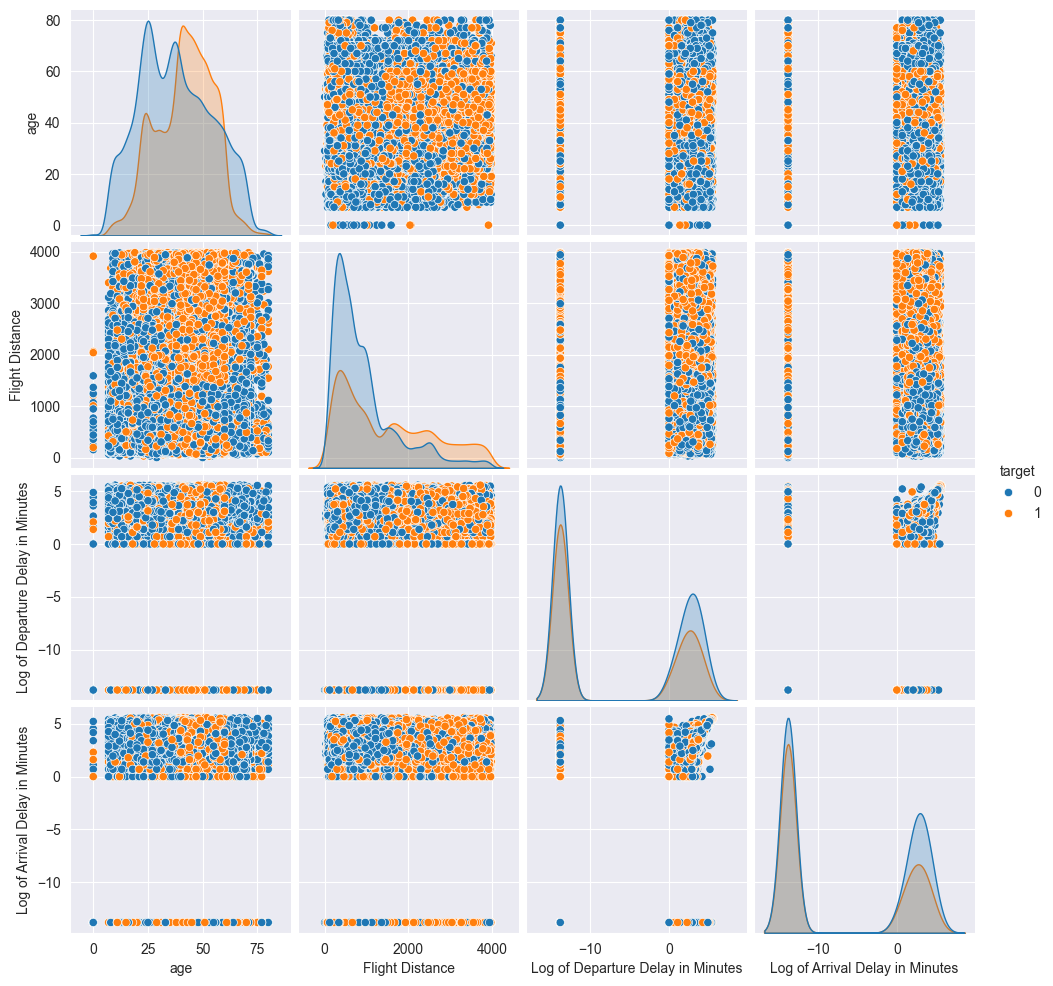

In [188]:
X_train_with_target = X_train.copy()
X_train_with_target['target'] = y_train
g = sns.pairplot(X_train_with_target[continuous_cols + ['target']], hue='target')

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [189]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False)
one_hot_encoder = one_hot_encoder.fit(X_train[categorical_cols])
encoded_cat_columns = one_hot_encoder.get_feature_names_out(categorical_cols)

X_train_ohe = pd.concat(
    [
        X_train.drop(categorical_cols, axis=1).reset_index(drop=True),
        pd.DataFrame(one_hot_encoder.transform(X_train[categorical_cols]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

X_val_ohe = pd.concat(
    [
        X_val.drop(categorical_cols, axis=1).reset_index(drop=True), 
        pd.DataFrame(one_hot_encoder.transform(X_val[categorical_cols]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [190]:
model = DecisionTreeClassifier().fit(X_train_ohe, y_train)
print("accuracy_score:", accuracy_score(y_val, model.predict(X_val_ohe)))

accuracy_score: 0.9423303256178893


## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [191]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, loss='0-1_loss', random_seed=42)
error_dt, bias_dt, var_dt

(0.06180070615927814, 0.04063685105270041, 0.04604223878645221)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

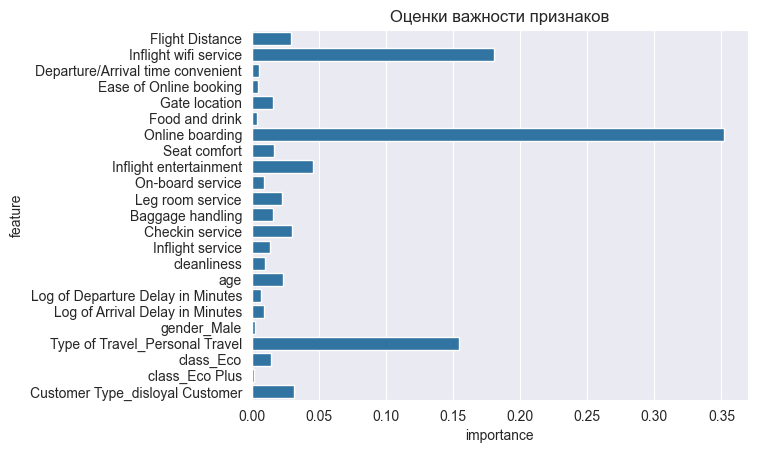

In [192]:
feature_scores = pd.DataFrame()
feature_scores['feature'] = X_train_ohe.columns
feature_scores['importance'] = model.feature_importances_
g = sns.barplot(feature_scores, y = 'feature', x = "importance",)
plt.title('Оценки важности признаков')
plt.show()

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

Наиболее информативными оказались признаки Online boarding, Inflight wifi service и полученный в результате OneHot-кодирования Type of Travel_PersonalTravel 


<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [193]:
print(f'Глубина дерева: {model.tree_.max_depth}. \nКоличество листьев: {model.tree_.n_leaves}')

Глубина дерева: 31. 
Количество листьев: 2096


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [194]:
most_important_features = ['Online boarding', 'Inflight wifi service']
model = DecisionTreeClassifier(max_depth=5).fit(X_train_ohe[most_important_features], y_train)
print("accuracy_score:", accuracy_score(y_val, model.predict(X_val_ohe[most_important_features])))

accuracy_score: 0.824833267948215


Качество на валидационной выборке упало примерно на 0.12 (~0.82 против ~0.94)

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

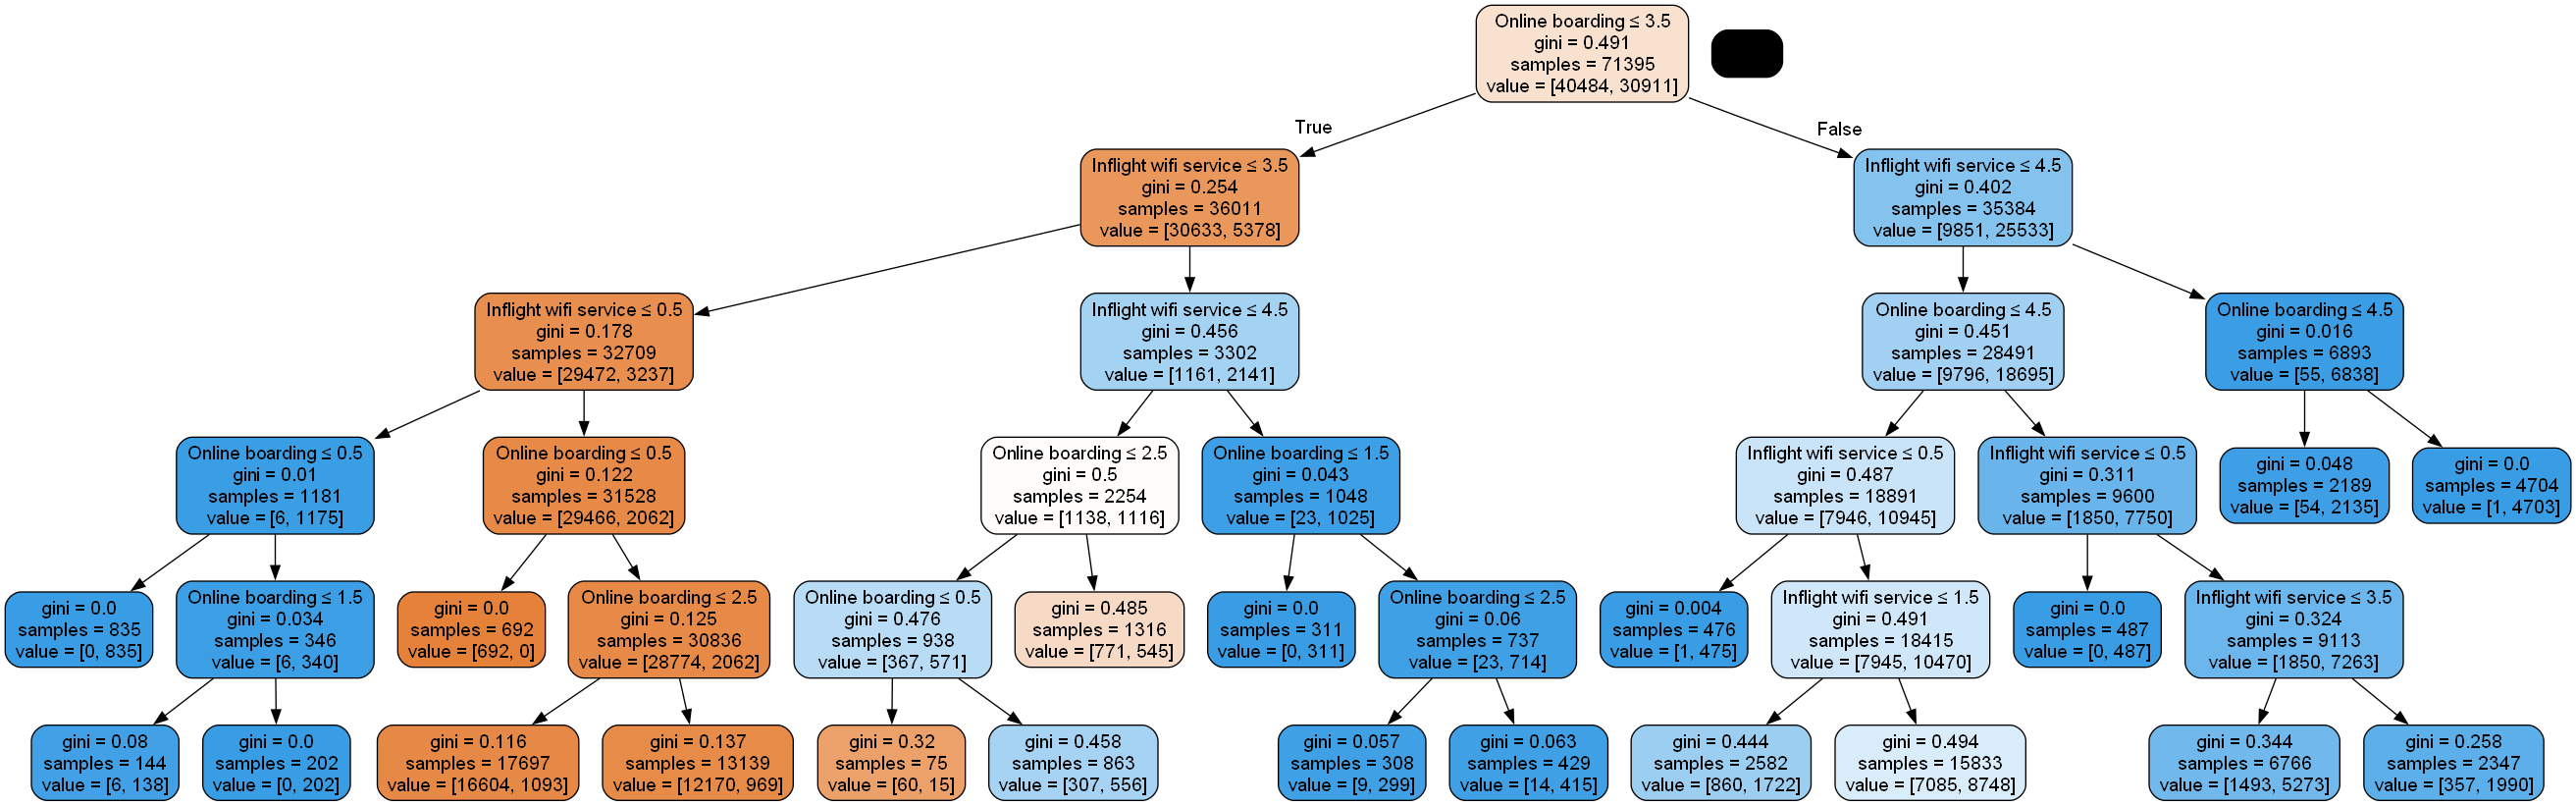

In [195]:
# feel free to google
"""
Т.к. отображаемое с помощью самой graphviz дерево почему-то не сохраняется в 
ноутбуке, сохраним его в png-файл, а потом отобразим как изображение. 
За основу взят код отсюда: 
 https://stackoverflow.com/questions/57488294/how-to-download-the-image-created-using-graphviz
"""
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz

data = StringIO()
# Экспорт структуры дерева в формате dot
export_graphviz(
    model, feature_names=most_important_features,
    filled=True, rounded=True, special_characters=True,
    out_file=data
)

filename = 'my_decision_tree.png'
graph = pydotplus.graph_from_dot_data(data.getvalue())  
graph.write_png(filename)
from PIL import Image
img = Image.open(filename)
img

> Все признаки в наборе данных являются целочисленными, поэтому в узлах дерева пороговые значения предикатов подбираются из значений, расположенных между ними. Соответственно, __поэтому они кратны 1/2__

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [196]:
top2_cont_features = feature_scores[feature_scores['feature'].apply(lambda x: x in continuous_cols)].sort_values(by='importance', ascending=False).head(2)['feature'].tolist()
model = DecisionTreeClassifier(max_depth=5).fit(X_train_ohe[top2_cont_features], y_train)
print("accuracy_score:", accuracy_score(y_val, model.predict(X_val_ohe[top2_cont_features])))

accuracy_score: 0.6836667974369034


(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

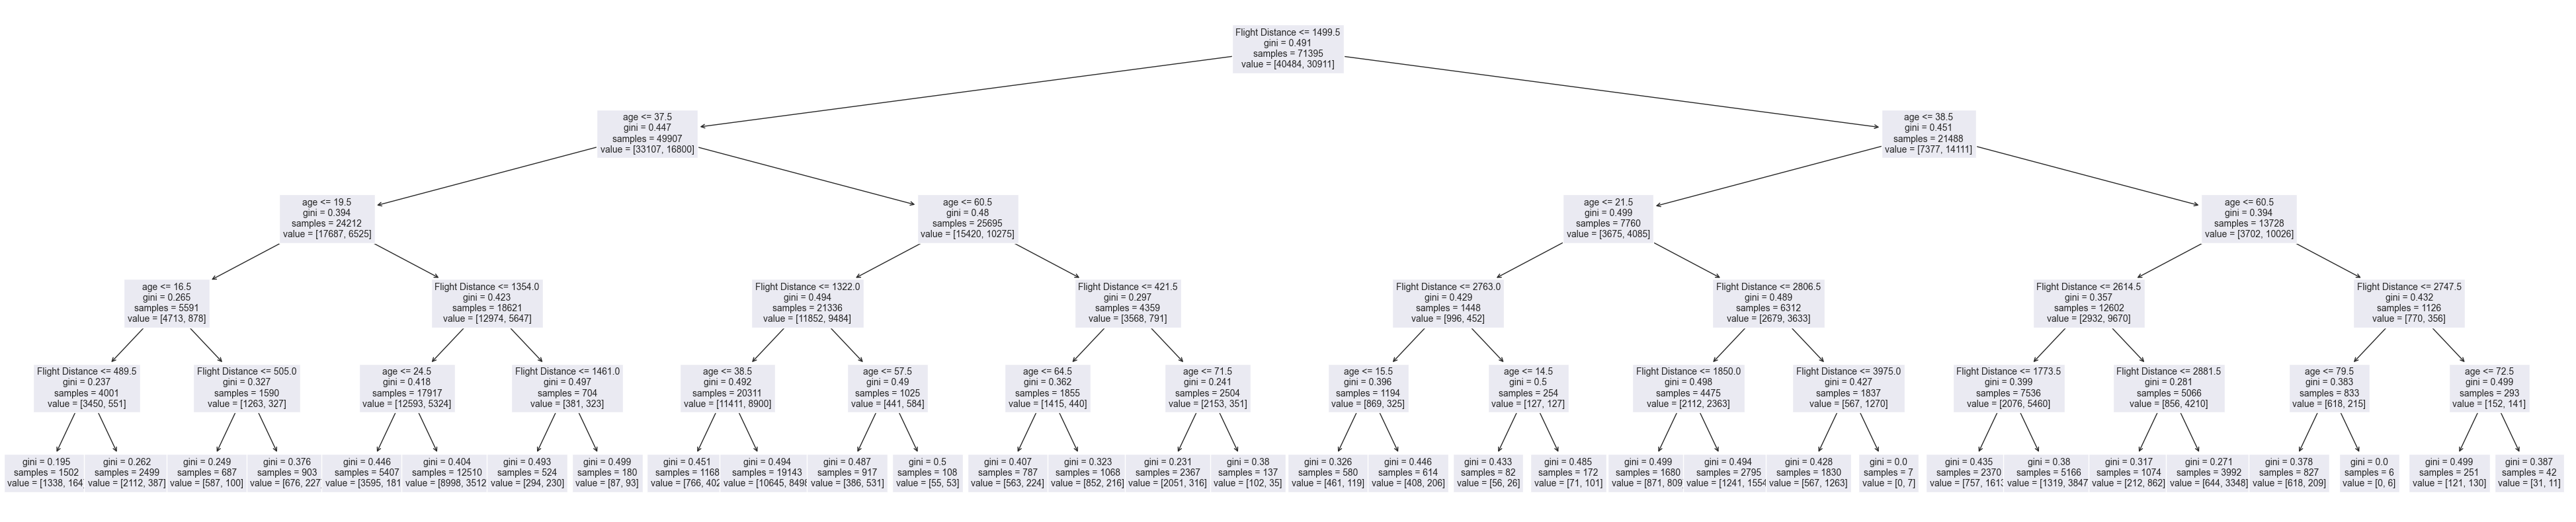

In [197]:
from sklearn import tree
plt.figure(figsize=(50,10))
tree.plot_tree(model, feature_names=top2_cont_features, fontsize=10)
plt.show()

Полученное дерево является симметричным. Представляется, что это хорошо, т.к. во-первых, это ведет к ускорению процесса предсказания, а во-вторых, может говорит о том, что оно не переобучено.

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

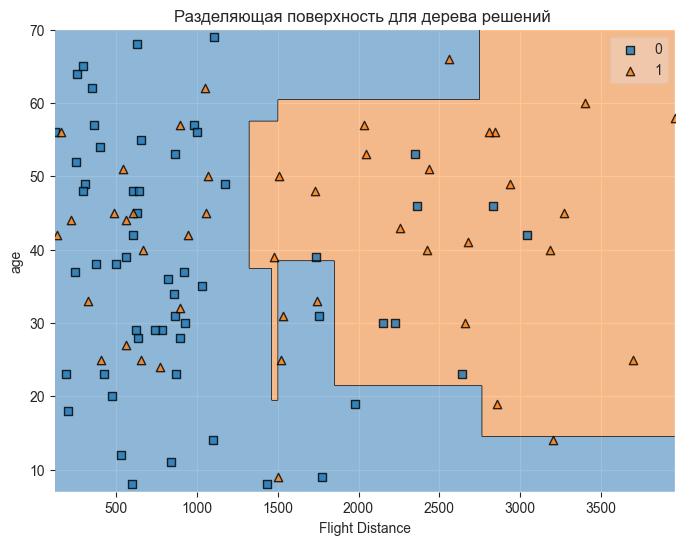

In [198]:
plt.figure(figsize=(8, 6))
plot_decision_regions(X_train_ohe[top2_cont_features].head(100).values, np.array(y_train[:100]),
                      clf=model, legend=1)

plt.xlabel(top2_cont_features[0])
plt.ylabel(top2_cont_features[1])
plt.title("Разделяющая поверхность для дерева решений ")
plt.show()

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

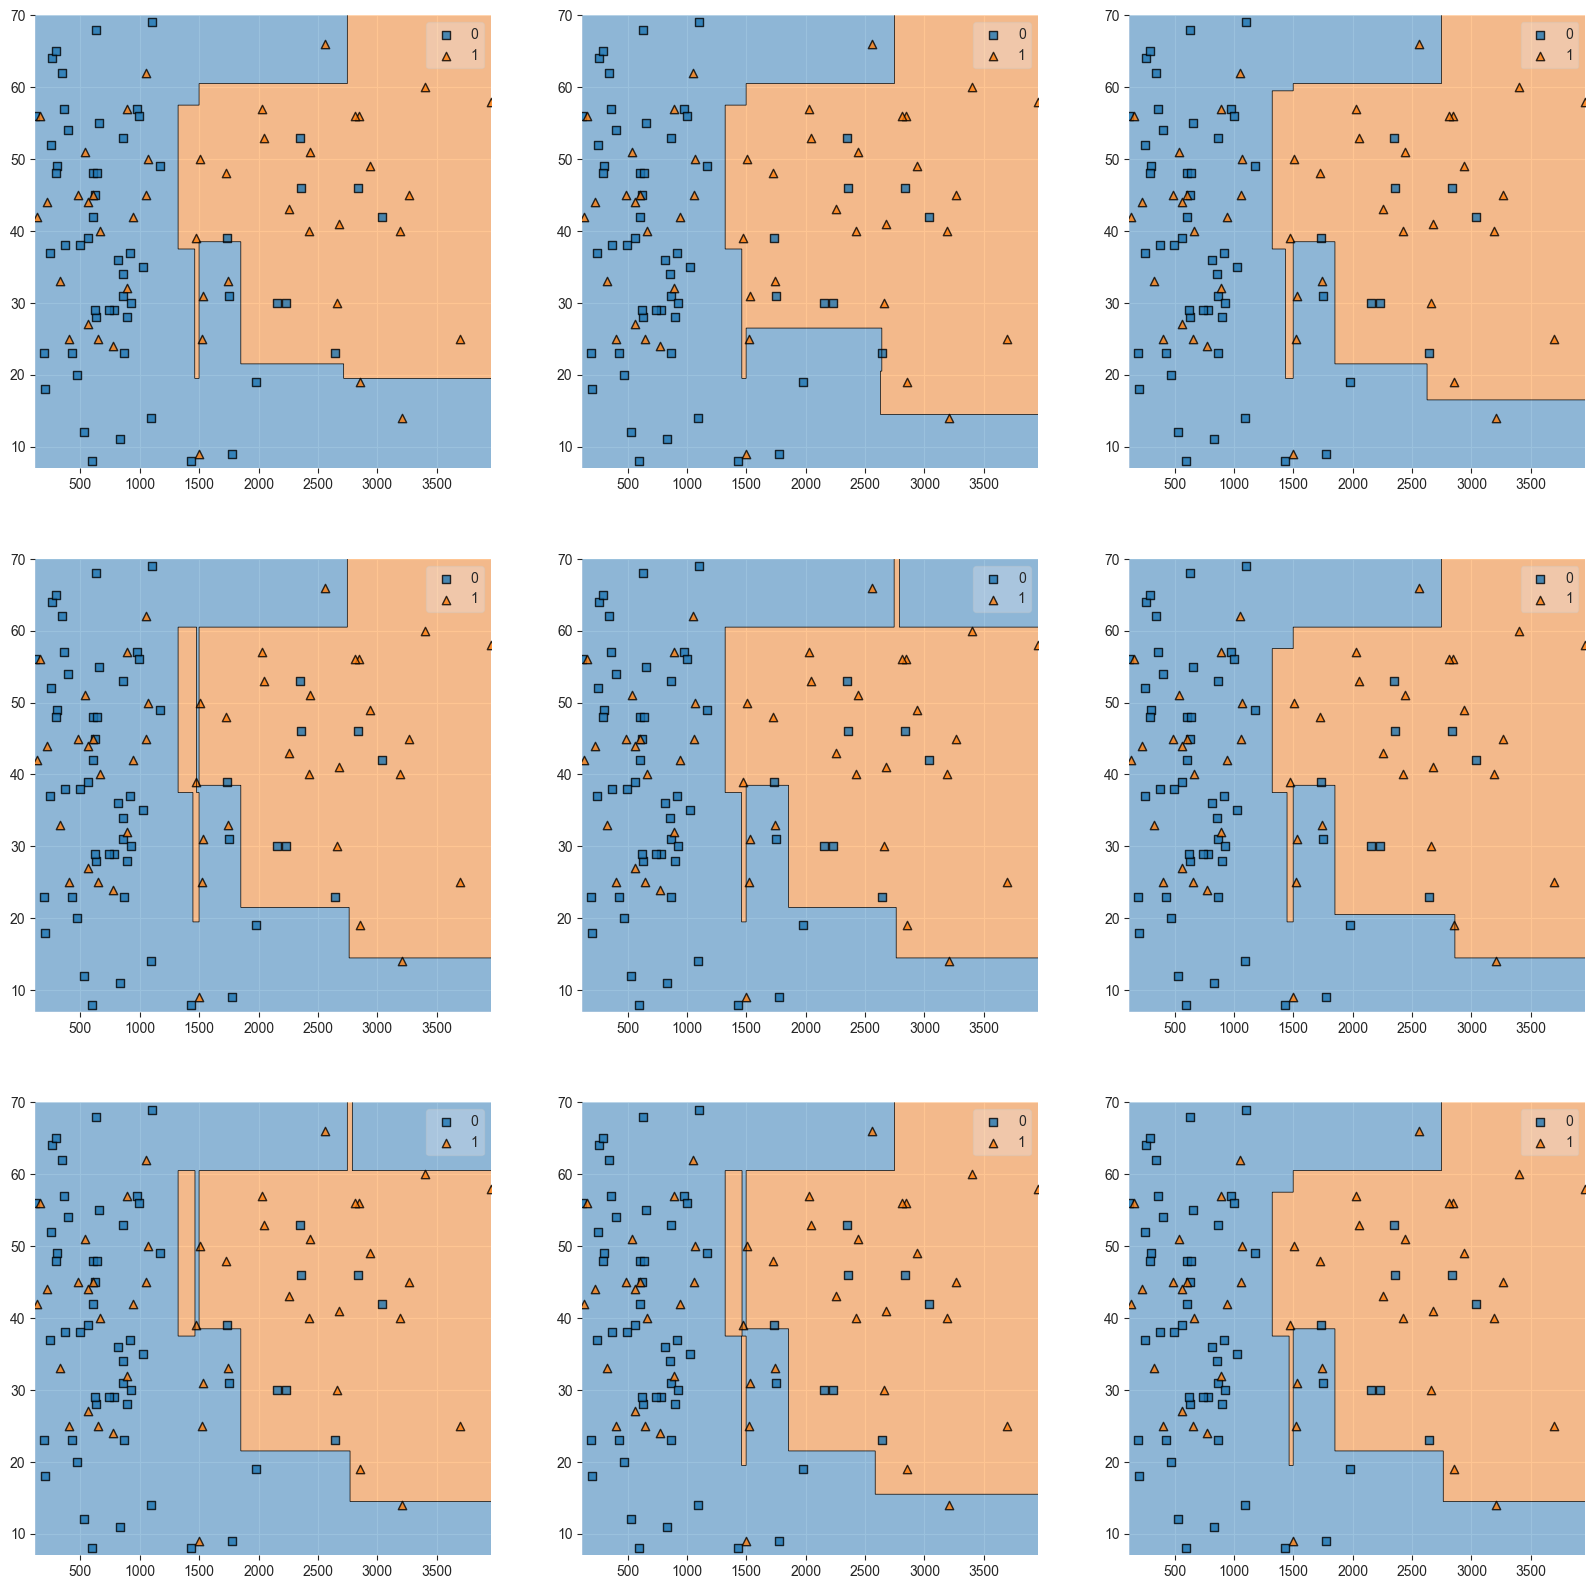

In [199]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_ohe.index, size=X_train_ohe.shape[0] - 5000, replace=False) 
        # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_ohe[top2_cont_features].loc[inds, :], y_train.iloc[inds])

        plot_decision_regions(X_train_ohe[top2_cont_features].head(100).values, np.array(y_train[:100]),
                              clf=tree_exp, legend=1, ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по 5000 случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [200]:
%%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_ohe, y_train)
    y_predicted_train = DT.predict(X_train_ohe)
    y_predicted_val = DT.predict(X_val_ohe)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: total: 2.25 s
Wall time: 3.24 s


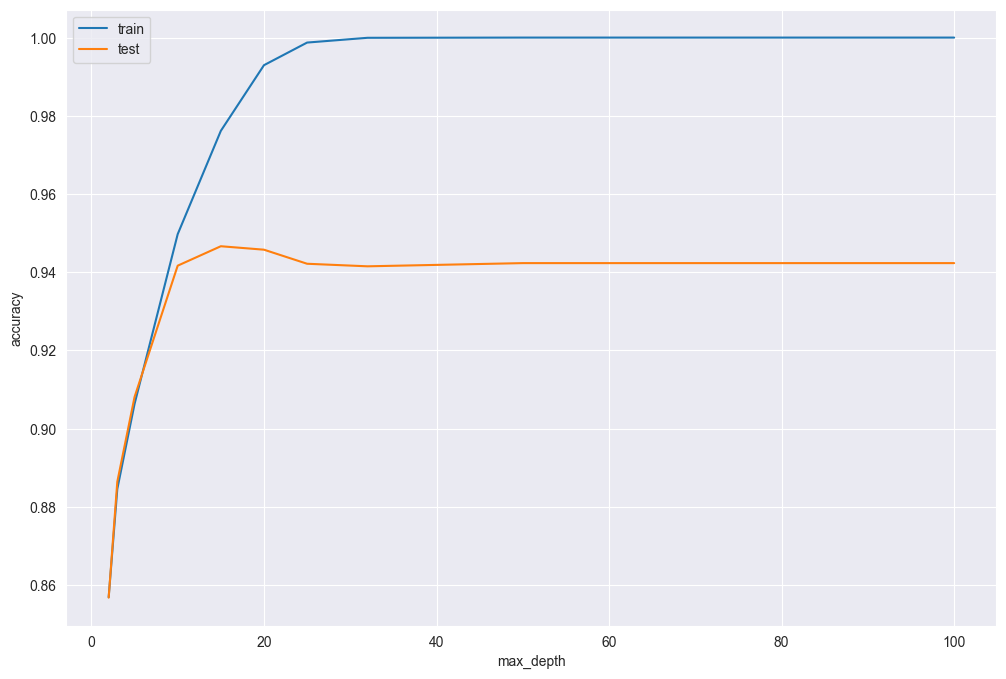

In [201]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [205]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(2, 20),
              'max_features': range(2, 22)}

model2 = DecisionTreeClassifier()
grid_search = GridSearchCV(model2, param_grid, cv=5)
grid_search.fit(X_train_ohe, y_train)

print("Оптимальные значения гиперпараметров:", grid_search.best_params_)
model2 = grid_search.best_estimator_

Оптимальные значения гиперпараметров: {'max_depth': 13, 'max_features': 17}


In [206]:
print("accuracy_score:", accuracy_score(y_val, model2.predict(X_val_ohe)))

accuracy_score: 0.9508957761213548


Качество предсказаний удалось улучшить, но незначительно, всего на ~ 0.01 (~0.95 против ~0.94) 

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [207]:
import pickle
with open('DT.pkl', 'wb') as f:
    pickle.dump(model2, f)

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [209]:
model = RandomForestClassifier().fit(X_train_ohe, y_train)
print("accuracy_score:", accuracy_score(y_val, model.predict(X_val_ohe)))

accuracy_score: 0.9614227801752321


(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

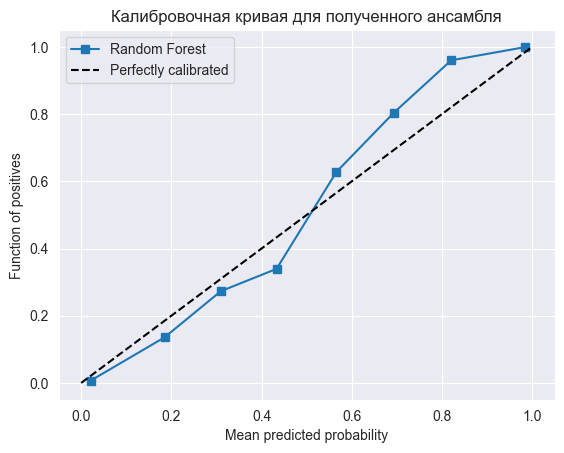

In [217]:
from sklearn.calibration import calibration_curve


fraction_of_positives, mean_predicted_proba = calibration_curve(y_val, model.predict_proba(X_val_ohe)[:, 1], n_bins=8)

plt.plot(mean_predicted_proba, fraction_of_positives, "s-", label="Random Forest")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.title("Калибровочная кривая для полученного ансамбля")
plt.xlabel("Mean predicted probability")
plt.ylabel("Function of positives")
plt.legend()
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

Согласно документации для метода ```predict_proba()``` класса ```DecisionTreeClassifier```: The result of clf.predict_proba(X) is the predicted class probability which is the fraction of samples of the same class in a leaf ([источник](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)). В общем случае это значение не обязано быть оценкой реальной вероятности отнесения объекта к одному или другому классу. Такая же мысль была [озвучена и в чате предмета преподавателем](https://t.me/c/1935491788/3/1628)



<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

In [230]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=3000).fit(X_train_ohe, y_train)

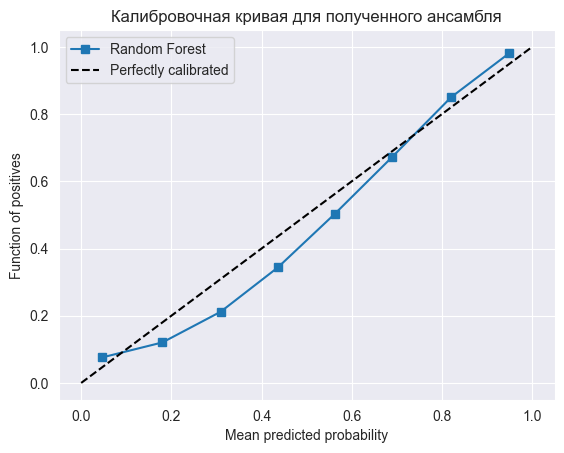

In [231]:
fraction_of_positives, mean_predicted_proba = calibration_curve(y_val, model_lr.predict_proba(X_val_ohe)[:, 1], n_bins=8)

plt.plot(mean_predicted_proba, fraction_of_positives, "s-", label="Random Forest")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.title("Калибровочная кривая для полученного ансамбля")
plt.xlabel("Mean predicted probability")
plt.ylabel("Function of positives")
plt.legend()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Для того чтобы алгоритм $b(x)$ правильно предсказывал вероятности, необходимо выполнение условия $$\underset{b\in \mathbb{R}} {arg\;min} \;\mathbb{E} [L(y, b)| x] = p(y=+1|x).$$ Этим условием обладает логистическая функция потерь $$L(y,z)=\log \left(1 + \exp(-yz)\right)$$

Логистическая регрессия представляет собой модель, которая строится путём минимизации данного функционала. Поэтому она дает корректные оценки вероятности принадлежности к положительному классу.



(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [0]:
"""Для калибровки, указанной в задании, воспользуемся CalibratedClassifierCV. 
Кроме того, разобьем тренировочную выборку на две подвыборки, на одной из которых
будем обучать модель, а на второй - калибровать"""
from sklearn.calibration import CalibratedClassifierCV

X_train_learning, X_train_calibration, y_train_learning, y_train_calibration = train_test_split(X_train_ohe, y_train, test_size=0.3, random_state=42)

model = RandomForestClassifier().fit(X_train_learning,y_train_learning)
model_calibrated_with_isotonic = CalibratedClassifierCV(estimator=model, method='isotonic').fit(X_train_calibration, y_train_calibration)
model_calibrated_with_logistic = CalibratedClassifierCV(estimator=model, method='sigmoid').fit(X_train_calibration, y_train_calibration)

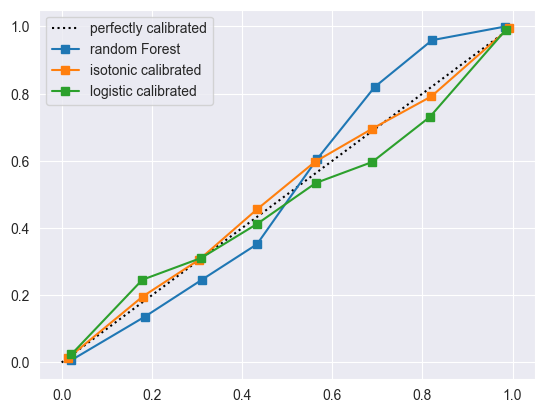

In [229]:
"""Теперь построим калибровочные кривые"""

plt.plot([0, 1], [0, 1], "k:", label="perfectly calibrated")

for m, name in [
    (model, "random Forest"), 
    (model_calibrated_with_isotonic, "isotonic calibrated"), 
    (model_calibrated_with_logistic, "logistic calibrated")
]:
    fraction_of_positives, mean_predicted_proba = calibration_curve(y_val, m.predict_proba(X_val_ohe)[:, 1], n_bins=8)
    plt.plot(mean_predicted_proba, fraction_of_positives, "s-", label=name)
plt.legend()
plt.show()

Как видим из графика не откалиброванная модель либо недооценивает, либо переоценивает вероятности. Логистическа калибровка дает чуть лучшую модель, но она по прежнему немного искажает вероятнсти. А вот результат изотонической калибровки ближе всех остальных к идеально откалиброванной модели  

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

1.  Деревья калибровки (Probability calibration trees). Строятся с использованием алгоритма, аналогичного деревьям логистической модели, за исключением того, что они используют два входных набора данных - исходные данные для обучения и связанные оценки базового классификатора, которые мы хотим откалибровать. Исходные данные для обучения используются для построения базовой структуры дерева , а оценки вывода используются для обучения логистических моделей с использованием метода LogitBoost. [Источник](https://researchcommons.waikato.ac.nz/bitstream/handle/10289/11515/leathart17a.pdf?sequence=4&isAllowed=y)

2. Temperature Scaling - в данном подходе происходит обучение единственного параметра температуры, который регулирует выход softmax. Предсказанные вероятности делятся на значение температуры, а затем  функция softmax применяется снова [Источник](https://medium.com/@eskandar.sahel/applying-calibration-techniques-to-improve-probabilistic-predictions-in-machine-learning-models-c175c2e38ffc)

3. Bayesian Binning into Quantiles (BBQ) - в данном подходе предполагается, что предсказанные вероятности разделены на интервалы (bins), а истинные вероятности в каждом интервале имеют бета-распределение. BBQ оценивает параметры бета-распределения для каждого интервала, используя эмпирические вероятности. [Источник](https://medium.com/@eskandar.sahel/applying-calibration-techniques-to-improve-probabilistic-predictions-in-machine-learning-models-c175c2e38ffc)



(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [232]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, loss='0-1_loss', random_seed=42)
print(f'Error: {error_dt}. Bias: {bias_dt}. Variance: {var_dt}') 

Error: 0.04087109323917876. Bias: 0.039329148685759124. Variance: 0.00918056100431542


Полученные значения смещения (~ 0.039) и разброса (~ 0.009) отличаются от полученных ранее для дерева решения (~ 0.041 и ~ 0.460, соответственно): смещение изменилось не сильно, а вот разброс существенно сократился, что объяснимо, т.к. ансаблирование моделей как раз уменьшает разброс но не сильно влияет на смещение. 

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [253]:
"""В связи с тем, что вычисления в данной ячейке выполняются очень долго, уменьшим количество раундов (num_rounds) до 30 """
lr_error, lr_bias, lr_var = bias_variance_decomp(model_lr,X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, 
                                          loss = '0-1_loss', num_rounds=50, random_seed = 42)
print(f'Error: {lr_error}. Bias: {lr_bias}. Variance: {lr_var}') 

Error: 0.12397345364195107. Bias: 0.12364325879429842. Variance: 0.004785536811821629


По цифрам видим, что смещение стало существенно выше, а разброс, наоборот - меньше, что объяснимо, т.к. модель логистической регрессии является более простой, и это ведет к большему смещениеюно в то же время она не так склонна к переобучению, что приводит к меньшему разбросу.

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [234]:
"""для подбора параметров из uniform-распределения, учитывая, что подбираемые 
 параметры будут дискретными, будем использовать randint из scipy.stats"""
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

m = RandomForestClassifier()
param_distributions = {
    'max_depth': randint(2, 30),
    'n_estimators':  randint(50, 300),
    'min_samples_leaf': randint(2, 10),
}

random_search = RandomizedSearchCV(m, param_distributions=param_distributions, cv=5, n_iter=10, random_state=42)

best_random_forest = random_search.fit(X_train_ohe, y_train).best_estimator_
print("Оптимальные значения гиперпараметров:", random_search.best_params_)

Оптимальные значения гиперпараметров: {'max_depth': 16, 'min_samples_leaf': 4, 'n_estimators': 121}


In [249]:
print("accuracy_score:", accuracy_score(y_val, best_random_forest.predict(X_val_ohe)))

accuracy_score: 0.9565188962992023


## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [254]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_ohe[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

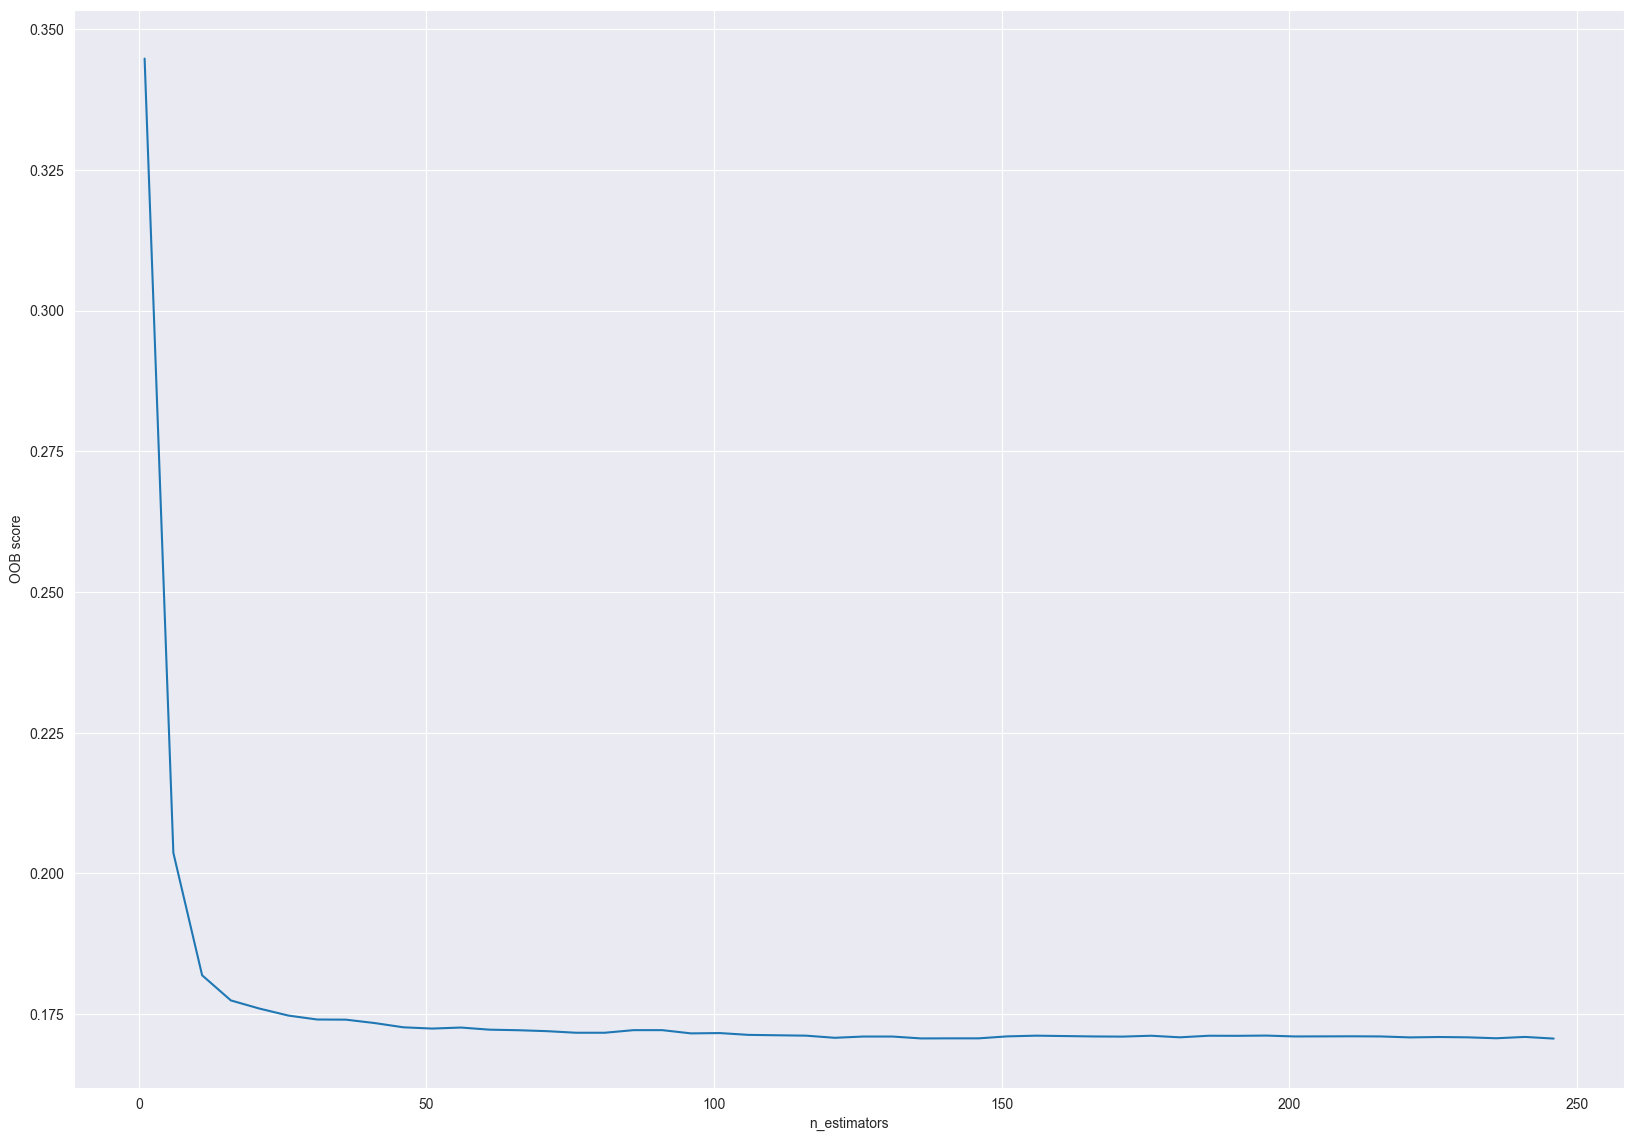

In [255]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

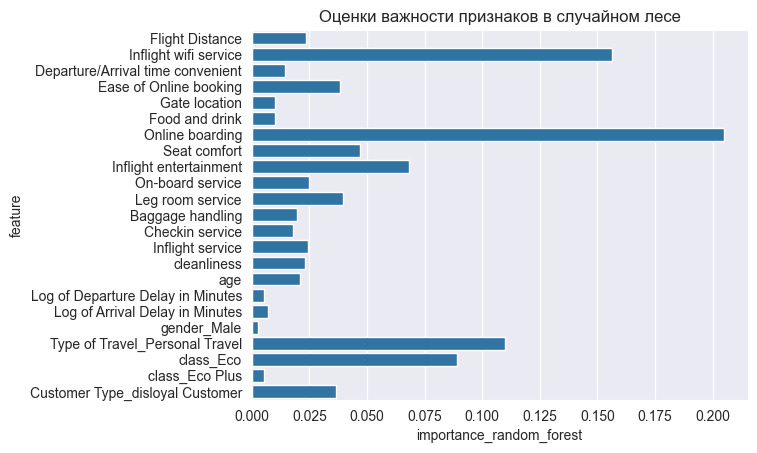

In [237]:
feature_scores['importance_random_forest'] = best_random_forest.feature_importances_
g = sns.barplot(feature_scores, y = 'feature', x = "importance_random_forest",)
plt.title('Оценки важности признаков в случайном лесе')
plt.show()

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

<Axes: xlabel='Value', ylabel='Feature'>

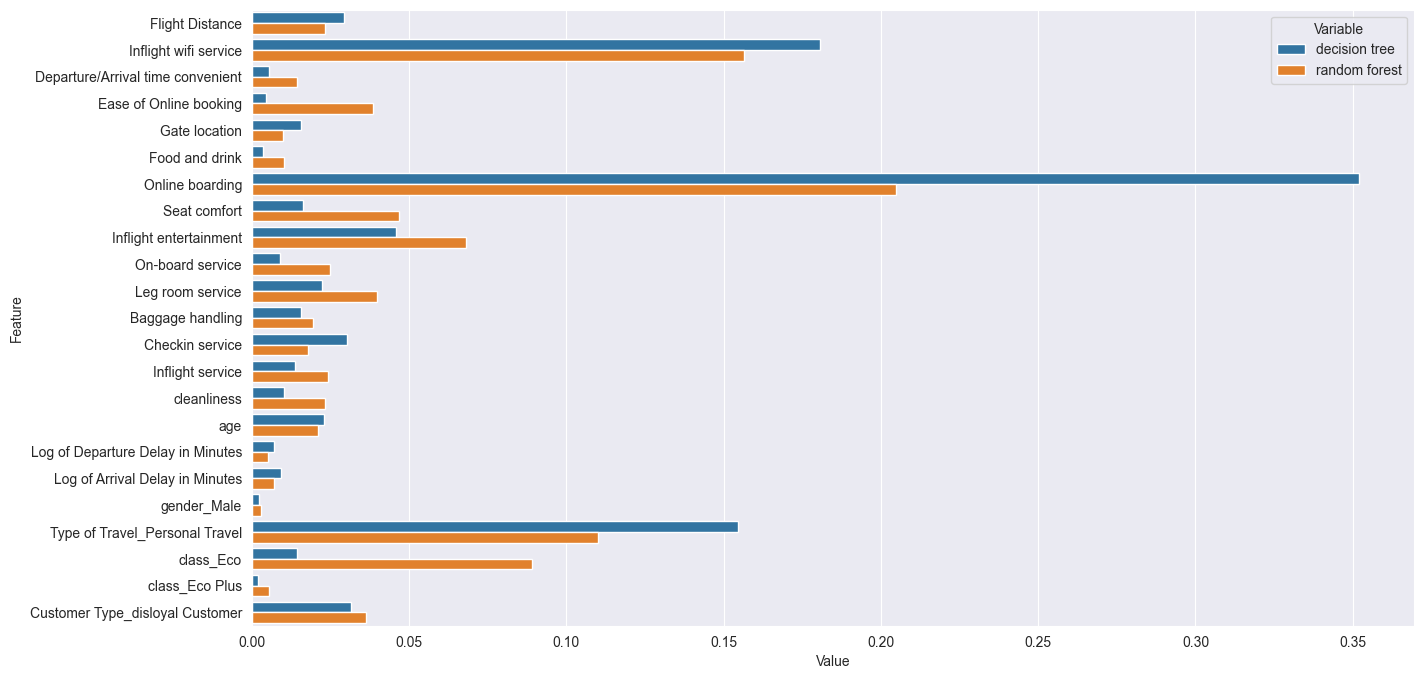

In [248]:
plt.figure(figsize=(15,8))
tidy = feature_scores.melt(id_vars='feature').rename(columns=str.title)
tidy['Variable'] = tidy['Variable'].apply(lambda x: "decision tree" if x == "importance" else "random forest")
sns.barplot(y='Feature', x='Value', hue='Variable', data=tidy,)

Из графика видим, что наиболее значимые признаки остались теми же, однако их вес немного снизился для случайного леса, в то время, значение некоторых других признаков (например, class_Eco) для случайного леса, наоборот, подросло 

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

100%|===================| 1999/2000 [02:03<00:00]        

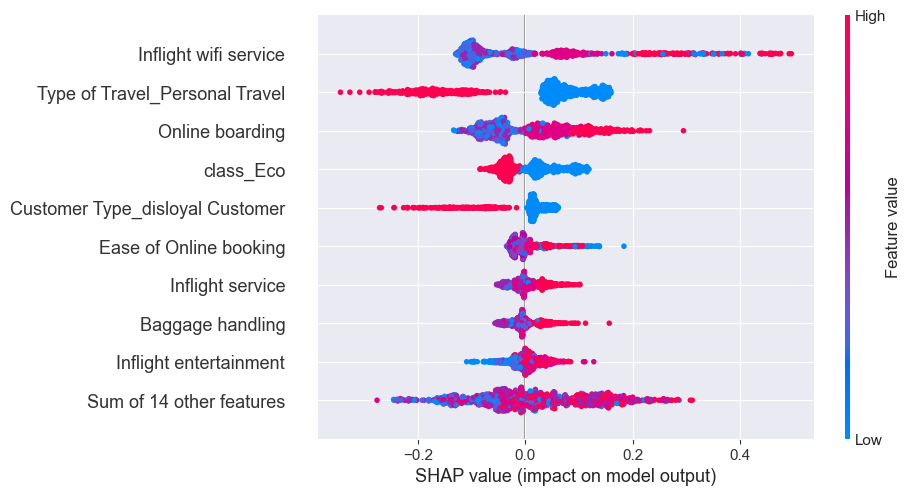

In [256]:
import shap
explainer = shap.Explainer(best_random_forest, shap.sample(X_train_ohe, 1000))
shap_values = explainer(shap.sample(X_train_ohe, 1000))
shap.plots.beeswarm(shap_values[:,:,1])

<font color='#FF6600'>Опишите полученый график</font>

Как и обычная гистограмма выше, полученный график отражает значимость признаков модели. Признаки расположены в порядке ее убывания и мы снова видим те же 3 наиболее значимых признака: Inflight wifi service, Type of Travel_Personal Travel и Online boarding. Кроме того, диаграмма отражает, как значения признаков влияют на вероятность отнесения объекта к одному из классов. Так, чем выше значение Online boarding (точки красные), тем выше вероятность отнесения объекта к классу 1 (удовлетворен), которому соответствуют правая часть графика. В то же время, чем больше значения Type of Travel_Personal Travel, тем выше вероятность отнесения объекта к классу 0 (не удовлетворен), которому соответствует левая часть графика.   


<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

Библиотека SHAP содержит набор инструментов, позволяющих оценить, насколько важен каждый признак для модели при прогнозировании. Это может быть полезной проверкой, чтобы убедиться, что модель ведет себя разумным образом, а именно соответствует ли ее поведение соображениям здравого смысла и знаниям экспертов соответствующей предметной области. 

В составе библиотеки имеются следующие средства анализа значимости признаков: 
- __Waterfall диаграмма__ - объясняет вклад каждой характеристики в прогноз для одного объекта. Структура waterfall диаграммы подчеркивает аддитивную природу положительных и отрицательных влияний различных признаков, а также то, как они формируют прогнозное значение.
![](waterfall_diag.png)
- __Force plots__ - в отличие от waterfall-диаграмм, которые являются подробными, force диаграммы отображают ключевую информацию в более компактном формате. Force-диаграммы полезны для изучения прогнозов для нескольких объектов сразу, поскольку их компактная конструкция это позволяет.
![](forceplot_diag.png)
- __Dependence-диаграммы__. В то время как Beeswarm диаграмма, которую мы строили выше, богата информацией и обеспечивают общий обзор SHAP значений для множества признаков одновременно, чтобы полностью понять взаимосвязь между значениями признака и прогнозируемыми результатами модели, необходимо изучить dependence диаграммы.
![](dependanceplot_diag.png) 
_Более подробно о возможностях библиотеки можно посмотреть [здесь](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)_


Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [266]:
import lime
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_ohe.astype(int).values, mode='classification', feature_names=X_train_ohe.columns)
obj_to_explain_ind = 11597
explanation = explainer.explain_instance(X_train_ohe.loc[obj_to_explain_ind].astype(int).values,lambda x: best_random_forest.predict_proba(x))
explanation.show_in_notebook(show_table=True)

К сожалению результат работы блока кода выше нормально не сохраняется в ноутбуке, поэтому ниже вставлен скрин результата. Его можно воспроизвести в ячейке выше, если запустть ноутбук

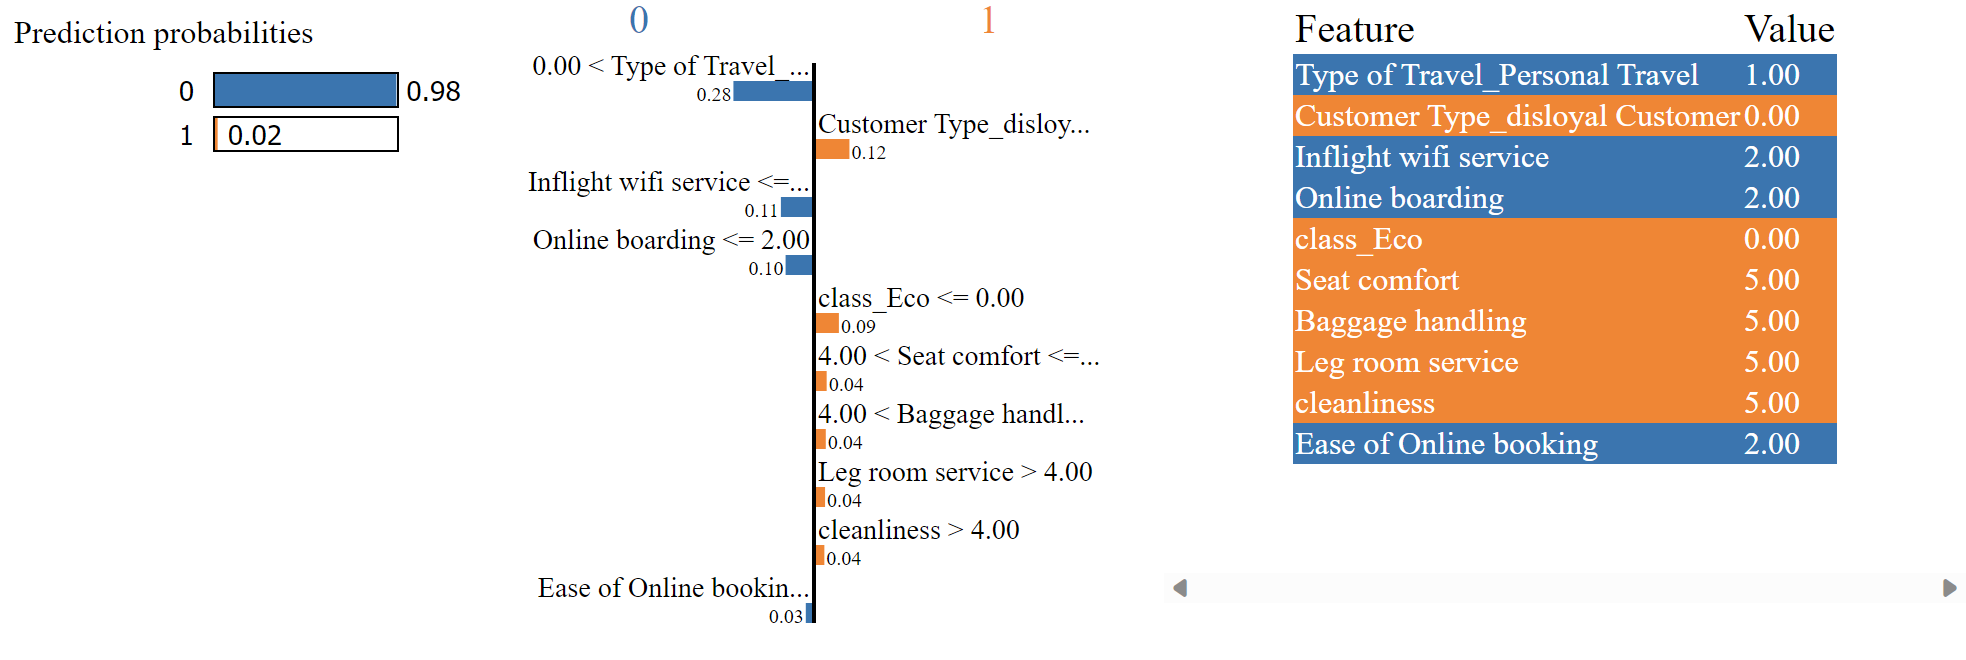

In [262]:
img = Image.open("lime_explanation.png")
img

<font color='#FF6600'>Опишите полученый график</font>

На приведенном графике признаки расположены в порядке убывания их значимости для прогнозного значения. Как и раньше мы видим те же три наиболее значимые признака: Type of Travel_Personal Travel, Customer Type_disloyal Customer, и Inflight wifi service. Также на диаграмме мы видим вклад признака в полученное прогнозное значение: так значение Customer Type_disloyal Customer, равное 0 приведет к уменьшению прогноза отнесения клиента к классу 0 с 0,94 до 0,83 (0,94-0,11 = 0,83). 
    


<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

In [264]:
with open('RF.pkl', 'wb') as f:
    pickle.dump(best_random_forest, f)

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?